In [1]:
import warnings
warnings.filterwarnings("ignore")

import torch
import torch.nn as nn
import torch.optim as optim

import torchtext
from torchtext.datasets import Multi30k
from torchtext.data import Field, BucketIterator

import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

import spacy
import numpy as np
import matplotlib

import random
import math
import time
import random
from yellowbrick.text import TSNEVisualizer
from sklearn.decomposition import PCA
from sklearn.metrics.pairwise import cosine_similarity

#Try multihead inanother notebook

In [2]:
#these are initial parameters you can change but, u have to play with configurations
#so best is keeping these simple,and testing
HID_DIM = 64
ENC_LAYERS = 1
DEC_LAYERS = 1
ENC_HEADS = 1
DEC_HEADS = 1
ENC_PF_DIM = 128
DEC_PF_DIM = 128
ENC_DROPOUT = 0.1
DEC_DROPOUT = 0.1

def get_head_count():
    return ENC_HEADS

def get_row_count():
    return 1

def get_col_count():
    return 1

In [3]:
#utility class to log all intermediate steps
#here saving all tensors send to add_info
#then we can query the intermediate steps
class StepLogger():
    def __init__(self,capacity):
        self.tensor_datas = {}        
        self.capacity = capacity
        self.added_labels = []
        
    
    def add_info(self,tensor_data,tensor_label):
        if tensor_label not in self.added_labels:
            self.added_labels.append( tensor_label )
        
        if tensor_label in self.tensor_datas.keys():
            current_arr = self.tensor_datas.get(tensor_label)
            if len(current_arr) < self.capacity:
                current_arr = self.tensor_datas.get(tensor_label, [])
                current_arr.append(tensor_data)
        else:
            self.tensor_datas[tensor_label] = [tensor_data]
    
    def get_default_summary(self,show_data=False,summary_count=1):
        self.get_summary(self.added_labels,show_data,show_info=True,summary_count=summary_count)
        
    def get_summary(self,labels,show_data=False,show_info=False,summary_count=1):
        if show_info:
            print("summary_count",summary_count,"   self.capacity ",self.capacity)
        count = 0
        values = []
        for i in range(summary_count):
            #print(i," ------------------------------------------------")
            for l in labels:
                if i < len(self.tensor_datas.get(l)):
                    label_data = self.tensor_datas.get(l)[i]
                    values.append(label_data)
                    if show_info:
                        print(l)
                    if torch.is_tensor(label_data):
                        if show_info:
                            print( list(label_data.size() ) )
                    if not show_data and not torch.is_tensor(label_data):
                        if show_info:
                            print(label_data)
                    if show_data:    
                        print(label_data)
        return values              
                    
loggers = {}                    
current_logger = StepLogger(100)   
def add_new_logger(logger_label):
    global current_logger
    if logger_label in loggers.keys() :
        print("using existing logger")
        current_logger = loggers[logger_label]
    else:    
        loggers[logger_label]  = StepLogger(50)
        current_logger = loggers[logger_label]
    

def add_infos(datas,labels,labels_prefix=""):
    #print( id(current_logger))
    for i in range(len(datas)):
        final_label = labels_prefix+"@"+labels[i]
        current_logger.add_info(datas[i],final_label.strip())
    
#add_info   tensor_data,tensor_label                  currentLogger.get_default_summary(show_data=False)

data_pipeline = []
pipeline_enabled = True
#do no want to log during eval mode
def disable_pipeline():
    global pipeline_enabled
    pipeline_enabled = False

def enable_pipeline():
    global pipeline_enabled
    pipeline_enabled = True

#sometimes i want to log some values selectively by enable/disable
#u can check how do i do use this at code, my intention is to collect
#some intermediate values
def add_pipeline_info(label,data):
    if pipeline_enabled:
        data_pipeline.append( (label,data) )
    

In [4]:
#my dummy variables for enabling/disabling some parts of network
APPLY_EVERYTHING = 1
APPLY_ONLY_TARGET_WITHOUT_SCALE = 2
APPLY_ONLY_TARGET_EMBEDDING = 3
APPLY_ONLY_SOURCE_EMBEDDING = 4
APPLY_ONLY_POS_EMBEDDING = 5
APPLY_ONLY_TARGET_WITH_SCALE = 6
#7 missing :) 9 also missing
APPLY_NOT_ATTENTION = 8

APPLY_NOT_DECODER_SELFATTENTION = 10
APPLY_ONLY_NORM_DECODER_SELFATTENTION = 11
APPLY_ONLY_DECODER_SELFATTENTION = 12
APPLY_ONLY_DROPOUT_DECODER_SELFATTENTION = 13
APPLY_NOT_POSITIONWISE = 14


#---------- Attention Types
ATTENTION_DEFAULT = 1
ATTENTION_EQUAL_DISTRIBUTED = 2
ATTENTION_AT_BEGINNING = 3
ATTENTION_AT_END = 4



In [5]:
SEED = 1234

random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.backends.cudnn.deterministic = True

In [6]:
def tokenize(text):
    return [tok for tok in text.split(" ")]


In [7]:
SRC = Field(tokenize = tokenize, 
            init_token = '<sos>', 
            eos_token = '<eos>', 
            lower = True, 
            batch_first = True)

TRG = Field(tokenize = tokenize, 
            init_token = '<sos>', 
            eos_token = '<eos>', 
            lower = True, 
            batch_first = True)

In [8]:
tabular_set = torchtext.data.TabularDataset(
path='D:/nnmedium/eng_de.csv', format='csv',
fields=[('src', SRC),('trg', TRG)])

In [9]:
#dump a sample
print(tabular_set[0].src)
print(tabular_set[0].trg)


['i', 'want', 'to', 'eat', 'bread']
['ich', 'mochten', 'brot', 'essen']


In [10]:

train_data, valid_data, test_data = tabular_set ,tabular_set, tabular_set

In [11]:
#all of our vocublary is used at least 2 times,  check the csv file
SRC.build_vocab(train_data, min_freq = 2)
TRG.build_vocab(train_data, min_freq = 2)

In [12]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device


device(type='cpu')

In [13]:
#our tranining size is so small so batch size will also be small
BATCH_SIZE = 8


In [14]:
train_iterator, valid_iterator, test_iterator = BucketIterator.splits(
    (train_data, valid_data, test_data), 
     batch_size = BATCH_SIZE,
     sort_key = lambda x:  len(x.src),
     device = device)

In [15]:
class Encoder(nn.Module):
    def __init__(self, 
                 input_dim, 
                 hid_dim, 
                 n_layers, 
                 n_heads, 
                 pf_dim,
                 dropout, 
                 device,
                 max_length = 100):
        super().__init__()

        self.device = device
        
        self.tok_embedding = nn.Embedding(input_dim, hid_dim)
        self.pos_embedding = nn.Embedding(max_length, hid_dim)
        
        self.layers = nn.ModuleList([EncoderLayer(hid_dim, 
                                                  n_heads, 
                                                  pf_dim,
                                                  dropout, 
                                                  device) 
                                     for _ in range(n_layers)])
        
        self.dropout = nn.Dropout(dropout)
        
        self.scale = torch.sqrt(torch.FloatTensor([hid_dim])).to(device)
        
    def forward(self, src, src_mask,attention_type):
    
        add_infos([src],["src_source"],"Encoder")
        add_pipeline_info(label="Encoder->attention",data=src)
        
        
        batch_size = src.shape[0]
        src_len = src.shape[1]
        
        pos = torch.arange(0, src_len).unsqueeze(0).repeat(batch_size, 1).to(self.device)
                
        src_embedding = self.tok_embedding(src) 
        add_infos([src,pos,src_embedding],["src","pos","src_embedding"],"Encoder")   
        src = self.dropout((src_embedding * self.scale) + self.pos_embedding(pos))                
        
        for layer in self.layers:
            src = layer(src, src_mask,attention_type)
            
        
        add_infos([src],["src_final"],"Encoder")            
            
        return src

In [16]:
class EncoderLayer(nn.Module):
    def __init__(self, 
                 hid_dim, 
                 n_heads, 
                 pf_dim,  
                 dropout, 
                 device):
        super().__init__()
        
        self.self_attn_layer_norm = nn.LayerNorm(hid_dim)
        self.ff_layer_norm = nn.LayerNorm(hid_dim)
        self.self_attention = MultiHeadAttentionLayer(hid_dim, n_heads, dropout, device,"encoder")
        self.positionwise_feedforward = PositionwiseFeedforwardLayer(hid_dim, 
                                                                     pf_dim, 
                                                                     dropout)
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, src, src_mask,attention_type):
                        
           
        #self attention
        _src, sattention = self.self_attention(src, src, src,attention_type, src_mask) #return x, attention
        
        #dropout, residual connection and layer norm
        src2 = self.self_attn_layer_norm(src + self.dropout(_src))
        
        ###At the end attention is learning a new representation for a sentence,here _src is a helper representation
        add_pipeline_info(label="EncoderSSS"+"@SSS",data=[src,_src,src2])  
                        
        #positionwise feedforward
        _src2 = self.positionwise_feedforward(src2)
        
        #dropout, residual and layer norm
        src3 = self.ff_layer_norm(src + self.dropout(_src2))
        
        add_infos([_src,src2,_src2,src3,src_mask,sattention],["_src","src2","_src2","src3","src_mask","sattention"],"EncoderLayer")        
        
        return src3

In [17]:
class MultiHeadAttentionLayer(nn.Module):
    #since this layer is common while logging there must be a label to differantiate labels
    def __init__(self, hid_dim, n_heads, dropout, device,layer_label):
        super().__init__()
        
        assert hid_dim % n_heads == 0
        
        self.hid_dim = hid_dim
        self.n_heads = n_heads
        #TODO head_dim is encoding per head so ,hid_dim must divide n_heads
        self.head_dim = hid_dim // n_heads
        self.layer_label = layer_label
        
        self.fc_q = nn.Linear(hid_dim, hid_dim)
        self.fc_k = nn.Linear(hid_dim, hid_dim)
        self.fc_v = nn.Linear(hid_dim, hid_dim)
        
        add_infos([self.hid_dim,self.n_heads,self.head_dim],["hid_dim","n_heads","head_dim"],self.layer_label)
        
        self.fc_o = nn.Linear(hid_dim, hid_dim)
        
        self.dropout = nn.Dropout(dropout)
        
        self.scale = torch.sqrt(torch.FloatTensor([self.head_dim])).to(device)
        
    def forward(self, query, key, value,attention_type, mask = None):
        
        batch_size = query.shape[0]
        
                
        Q = self.fc_q(query)
        K = self.fc_k(key)
        V = self.fc_v(value)
        
                
        Q = Q.view(batch_size, -1, self.n_heads, self.head_dim).permute(0, 2, 1, 3)
        K = K.view(batch_size, -1, self.n_heads, self.head_dim).permute(0, 2, 1, 3)
        V = V.view(batch_size, -1, self.n_heads, self.head_dim).permute(0, 2, 1, 3)
        
        
        add_infos([Q,K,V],["Q","K","V"],self.layer_label)
        
                
        energy = torch.matmul(Q, K.permute(0, 1, 3, 2)) / self.scale
               
        if mask is not None:
            energy = energy.masked_fill(mask == 0, -1e10)
                            
        attention = torch.softmax(energy, dim = -1)                
        
        ### attention is a weight over dimensions
        if attention_type == ATTENTION_EQUAL_DISTRIBUTED: #normally distributed literally means no attention            
            attention = torch.tensor(np.full(attention.shape, 1/attention.shape[3]),dtype=torch.float32 )
        #just pay attention to beginning
        #at last dimension shape is flat 1, 2, 1, 1    
        if attention_type == ATTENTION_AT_BEGINNING:           
            if attention.shape[3] > 2: 
                real_shape = attention.shape
                att1 = torch.tensor(np.full((real_shape[0], real_shape[1], real_shape[2], 3), 1/3) ,dtype=torch.float32 )
                att2 = torch.tensor(np.full((real_shape[0], real_shape[1], real_shape[2], real_shape[3] - 3), 1/7) ,dtype=torch.float32 )
                att3 = torch.cat( (att1,att2),3 )
                attention = torch.softmax(att3, dim = -1)
                
        if attention_type == ATTENTION_AT_END :           
            if attention.shape[3] > 2: 
                real_shape = attention.shape                
                att1 = torch.tensor(np.full((real_shape[0], real_shape[1], real_shape[2], real_shape[3] - 1), 0) ,dtype=torch.float32 )
                att2 = torch.tensor(np.full((real_shape[0], real_shape[1], real_shape[2], 1), 1) ,dtype=torch.float32 )
                att3 = torch.cat( (att1,att2),3 )
                attention = torch.softmax(att3, dim = -1)         
            
                
        x1 = torch.matmul(self.dropout(attention), V)
        
        add_pipeline_info(label=self.layer_label+"@QKV",data=[Q,K,V,mask,energy,attention,mask,x1])
        
        
        x2 = x1.permute(0, 2, 1, 3).contiguous()
        
        
        x3 = x2.view(batch_size, -1, self.hid_dim)
        
        
        x4 = self.fc_o(x3)
        
        
        add_infos([energy,mask,attention],["energy","mask","attention"],self.layer_label)
        add_infos([x1,x2,x3,x4],["x1","x2","x3","x4"],self.layer_label)
        
        return x4, attention

In [18]:
class PositionwiseFeedforwardLayer(nn.Module):
    def __init__(self, hid_dim, pf_dim, dropout):
        super().__init__()
        
        self.fc_1 = nn.Linear(hid_dim, pf_dim)
        self.fc_2 = nn.Linear(pf_dim, hid_dim)
        
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, x):
                
        x1 = self.dropout(torch.relu(self.fc_1(x)))
                
        x2 = self.fc_2(x1)
        
        add_infos([x1,x2],["x1","x2"],"PositionwiseFeedforwardLayer")
        
        return x2

In [19]:
class Decoder(nn.Module):
    def __init__(self, 
                 output_dim, 
                 hid_dim, 
                 n_layers, 
                 n_heads, 
                 pf_dim, 
                 dropout, 
                 device,
                 max_length = 100):
        super().__init__()
        
        self.device = device
        
        self.tok_embedding = nn.Embedding(output_dim, hid_dim)
        self.pos_embedding = nn.Embedding(max_length, hid_dim)
        
        self.layers = nn.ModuleList([DecoderLayer(hid_dim, 
                                                  n_heads, 
                                                  pf_dim, 
                                                  dropout, 
                                                  device)
                                     for _ in range(n_layers)])
        
        self.fc_out = nn.Linear(hid_dim, output_dim)
        
        self.dropout = nn.Dropout(dropout)
        
        self.scale = torch.sqrt(torch.FloatTensor([hid_dim])).to(device)
        
    def forward(self, trg, enc_src, trg_mask, src_mask,attention_type=1,pos_type=1):
        
       
        add_pipeline_info(label="Decoder_original->trg",data=trg)         
           
        batch_size = trg.shape[0]
        trg_len = trg.shape[1]
        
        pos = torch.arange(0, trg_len).unsqueeze(0).repeat(batch_size, 1).to(self.device)
                            
        trg_embedding   = self.tok_embedding(trg)
        if pos_type == APPLY_EVERYTHING : #apply everything (default)
            trg = self.dropout( (trg_embedding * self.scale) + self.pos_embedding(pos))
        elif pos_type == APPLY_ONLY_TARGET_WITHOUT_SCALE: #apply only target embedding wihtout scale
            trg = self.dropout( trg_embedding )
        elif pos_type == APPLY_ONLY_TARGET_EMBEDDING: #apply without dropout
            trg = trg_embedding
        elif pos_type == APPLY_ONLY_SOURCE_EMBEDDING: #just give encoder embedding,very bad embedding,expect worse!!!
            trg = enc_src    
        elif pos_type == APPLY_ONLY_POS_EMBEDDING: # apply only positional embedding
            trg = self.pos_embedding(pos)        
        elif pos_type == APPLY_ONLY_TARGET_WITH_SCALE: #apply only target embedding with scale
            trg = self.dropout( (trg_embedding * self.scale) )
        else:#put also default to not known type   
            trg = self.dropout( (trg_embedding * self.scale) + self.pos_embedding(pos))
                
        trg_before_attention = trg 
        
        for layer in self.layers:
            trg, attention = layer(trg, enc_src, trg_mask, src_mask,attention_type,pos_type)
        
        if pos_type == APPLY_NOT_ATTENTION : #revert back to vector before attention
            trg = trg_before_attention
            
        
        output = self.fc_out(trg)
        
        add_infos([pos,trg,output,attention,trg_embedding],["pos","trg","output","attention","trg_embedding"],"Decoder")
            
        return output, attention

In [20]:
class DecoderLayer(nn.Module):
    def __init__(self, 
                 hid_dim, 
                 n_heads, 
                 pf_dim, 
                 dropout, 
                 device):
        super().__init__()
        
        self.self_attn_layer_norm = nn.LayerNorm(hid_dim)
        self.enc_attn_layer_norm = nn.LayerNorm(hid_dim)
        self.ff_layer_norm = nn.LayerNorm(hid_dim)
        self.self_attention = MultiHeadAttentionLayer(hid_dim, n_heads, dropout, device,"decoder_self")
        self.encoder_attention = MultiHeadAttentionLayer(hid_dim, n_heads, dropout, device,"decoder_encoder_attention")
        self.positionwise_feedforward = PositionwiseFeedforwardLayer(hid_dim, 
                                                                     pf_dim, 
                                                                     dropout)
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, trg, enc_src, trg_mask, src_mask,attention_type,pos_type):
        
        
        #self attention
        add_pipeline_info(label="Decoder_self->attention",data=trg) 
        if pos_type == APPLY_NOT_DECODER_SELFATTENTION:
            _trg1 = trg
        else:
            _trg1, _ = self.self_attention(trg, trg, trg,attention_type, trg_mask)
        
        #dropout, residual connection and layer norm
        trg2 = self.self_attn_layer_norm(trg + self.dropout(_trg1))
            
            
            
        #encoder attention
        add_pipeline_info(label="Decoder->encoder_attention",data=trg2) 
        _trg2, attention = self.encoder_attention(trg2, enc_src, enc_src,attention_type, src_mask)
        
        if pos_type == APPLY_ONLY_NORM_DECODER_SELFATTENTION : #only apply decoder self attention with layer
            trg3 = self.enc_attn_layer_norm(trg2 )
        elif pos_type == APPLY_ONLY_DECODER_SELFATTENTION: #only apply decoder self attention
            trg3 = trg2    
        elif pos_type == APPLY_ONLY_DROPOUT_DECODER_SELFATTENTION: # only apply encoder attention
            trg3 = self.dropout(_trg2)        
        else:    
            #dropout, residual connection and layer norm
            trg3 = self.enc_attn_layer_norm(trg2 + self.dropout(_trg2))
                            
        #positionwise feedforward
        if pos_type == APPLY_NOT_POSITIONWISE:
            _trg3 = trg3
        else:    
            _trg3 = self.positionwise_feedforward(trg3)
        
        #dropout, residual and layer norm
        trg4 = self.ff_layer_norm(trg3 + self.dropout(_trg3))
        
        
        add_infos([_trg1,trg2,_trg2,trg3,_trg3,trg4,attention,trg_mask, src_mask],["_trg1","trg2","_trg2","trg3","_trg3","trg4","attention","trg_mask", "src_mask"],"DecoderLayer")
        
        return trg4, attention

In [21]:
class Seq2Seq(nn.Module):
    def __init__(self, 
                 encoder, 
                 decoder, 
                 src_pad_idx, 
                 trg_pad_idx, 
                 device):
        super().__init__()
        
        self.encoder = encoder
        self.decoder = decoder
        self.src_pad_idx = src_pad_idx
        self.trg_pad_idx = trg_pad_idx
        self.device = device
        
    def make_src_mask(self, src):
                
        src_mask = (src != self.src_pad_idx).unsqueeze(1).unsqueeze(2)

        return src_mask
    
    def make_trg_mask(self, trg):
                
        trg_pad_mask = (trg != self.trg_pad_idx).unsqueeze(1).unsqueeze(2)
                
        trg_len = trg.shape[1]
        
        trg_sub_mask = torch.tril(torch.ones((trg_len, trg_len), device = self.device)).bool()
                    
        trg_mask = trg_pad_mask & trg_sub_mask
                
        return trg_mask

    def forward(self, src, trg,attention_type):
        
                
        src_mask = self.make_src_mask(src)
        trg_mask = self.make_trg_mask(trg)
        
        enc_src = self.encoder(src, src_mask,attention_type)
                        
        output, attention = self.decoder(trg, enc_src, trg_mask, src_mask,attention_type)
        
        add_infos([src_mask,trg_mask,enc_src,output,attention,src,trg],["src_mask","trg_mask","enc_src","output","attention","src","trg"],"Seq2Seq")        
        
        return output, attention

In [22]:
INPUT_DIM = len(SRC.vocab)
OUTPUT_DIM = len(TRG.vocab)


enc = Encoder(INPUT_DIM, 
              HID_DIM, 
              ENC_LAYERS, 
              ENC_HEADS, 
              ENC_PF_DIM, 
              ENC_DROPOUT, 
              device)

dec = Decoder(OUTPUT_DIM, 
              HID_DIM, 
              DEC_LAYERS, 
              DEC_HEADS, 
              DEC_PF_DIM, 
              DEC_DROPOUT, 
              device)

In [23]:
SRC_PAD_IDX = SRC.vocab.stoi[SRC.pad_token]
TRG_PAD_IDX = TRG.vocab.stoi[TRG.pad_token]

model = Seq2Seq(enc, dec, SRC_PAD_IDX, TRG_PAD_IDX, device).to(device)

In [24]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f'The model has {count_parameters(model):,} trainable parameters')

The model has 99,857 trainable parameters


In [25]:
def initialize_weights(m):
    if hasattr(m, 'weight') and m.weight.dim() > 1:
        nn.init.xavier_uniform_(m.weight.data)

In [26]:
model.apply(initialize_weights)

Seq2Seq(
  (encoder): Encoder(
    (tok_embedding): Embedding(18, 64)
    (pos_embedding): Embedding(100, 64)
    (layers): ModuleList(
      (0): EncoderLayer(
        (self_attn_layer_norm): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
        (ff_layer_norm): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
        (self_attention): MultiHeadAttentionLayer(
          (fc_q): Linear(in_features=64, out_features=64, bias=True)
          (fc_k): Linear(in_features=64, out_features=64, bias=True)
          (fc_v): Linear(in_features=64, out_features=64, bias=True)
          (fc_o): Linear(in_features=64, out_features=64, bias=True)
          (dropout): Dropout(p=0.1, inplace=False)
        )
        (positionwise_feedforward): PositionwiseFeedforwardLayer(
          (fc_1): Linear(in_features=64, out_features=128, bias=True)
          (fc_2): Linear(in_features=128, out_features=64, bias=True)
          (dropout): Dropout(p=0.1, inplace=False)
        )
        (dropout): Dr

In [27]:
LEARNING_RATE = 0.0005

optimizer = torch.optim.Adam(model.parameters(), lr = LEARNING_RATE)

In [28]:
criterion = nn.CrossEntropyLoss(ignore_index = TRG_PAD_IDX)


In [29]:
def train(model, iterator, optimizer, criterion, clip,attention_type):
    
    model.train()
    
    epoch_loss = 0
    
    print("train1")
    
    for i, batch in enumerate(iterator):
        #print("train2",i,batch)
        
        
        src = batch.src
        trg = batch.trg
        
        #print("train src",src)
        
        optimizer.zero_grad()
        add_pipeline_info(label="train"+"@srctrg",data=[src,trg[:,:-1]]) 
        output, _ = model(src, trg[:,:-1],attention_type)
        
        
                
        #output = [batch size, trg len - 1, output dim]
        #trg = [batch size, trg len]
            
        output_dim = output.shape[-1]
        
        
            
        output = output.contiguous().view(-1, output_dim)
        trg = trg[:,1:].contiguous().view(-1)
                
        #output = [batch size * trg len - 1, output dim]
        #trg = [batch size * trg len - 1]
            
        loss = criterion(output, trg)
        
        loss.backward()
        
        torch.nn.utils.clip_grad_norm_(model.parameters(), clip)
        
        optimizer.step()
        
        epoch_loss += loss.item()
        
    return epoch_loss / len(iterator)

In [30]:
def evaluate(model, iterator, criterion,attention_type):
    
    model.eval()
    
    epoch_loss = 0
    
    with torch.no_grad():
    
        for i, batch in enumerate(iterator):

            src = batch.src
            trg = batch.trg

            
            output, _ = model(src, trg[:,:-1],attention_type)
            
            #output = [batch size, trg len - 1, output dim]
            #trg = [batch size, trg len]
            
            output_dim = output.shape[-1]
            
            output = output.contiguous().view(-1, output_dim)
            trg = trg[:,1:].contiguous().view(-1)
            
            #output = [batch size * trg len - 1, output dim]
            #trg = [batch size * trg len - 1]
            
            loss = criterion(output, trg)

            epoch_loss += loss.item()
        
    return epoch_loss / len(iterator)

In [31]:
def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

In [32]:
import os
import gc
N_EPOCHS = 30
CLIP = 1
best_valid_loss = float('inf')

add_new_logger("training")


model_save_path = "D:/nnmedium/tut6-model_en_de.pt"
model_to_train = model
for epoch in range(N_EPOCHS):
    gc.collect()
    if os.path.isfile(model_save_path) :
        print("loading model",model_save_path)
        #If you want to save the model enable below,do it for big datasets
        #model_to_train.load_state_dict(torch.load(model_save_path))
    
    start_time = time.time()
    
    enable_pipeline()
    train_loss = train(model, train_iterator, optimizer, criterion, CLIP,attention_type=1)
    
    disable_pipeline()
    valid_loss = evaluate(model, valid_iterator, criterion,attention_type=1)    
    
    end_time = time.time()
    
    
    epoch_mins, epoch_secs = epoch_time(start_time, end_time)
    
    
    if valid_loss < best_valid_loss:
        print("saving model",model_save_path," with loss ",valid_loss)
        best_valid_loss = valid_loss
        torch.save(model_to_train.state_dict(), model_save_path)
    print(f'Epoch: {epoch+1:02} | Time: {epoch_mins}m {epoch_secs}s')
    print(f'\tTrain Loss: {train_loss:.3f} | Train PPL: {math.exp(train_loss):7.3f}')
    print(f'\t Val. Loss: {valid_loss:.3f} |  Val. PPL: {math.exp(valid_loss):7.3f}')    

loading model D:/nnmedium/tut6-model_en_de.pt
train1
saving model D:/nnmedium/tut6-model_en_de.pt  with loss  2.7126770496368406
Epoch: 01 | Time: 0m 0s
	Train Loss: 3.247 | Train PPL:  25.706
	 Val. Loss: 2.713 |  Val. PPL:  15.070
loading model D:/nnmedium/tut6-model_en_de.pt
train1
saving model D:/nnmedium/tut6-model_en_de.pt  with loss  2.2611355066299437
Epoch: 02 | Time: 0m 0s
	Train Loss: 2.657 | Train PPL:  14.253
	 Val. Loss: 2.261 |  Val. PPL:   9.594
loading model D:/nnmedium/tut6-model_en_de.pt
train1
saving model D:/nnmedium/tut6-model_en_de.pt  with loss  1.9791063785552978
Epoch: 03 | Time: 0m 0s
	Train Loss: 2.348 | Train PPL:  10.464
	 Val. Loss: 1.979 |  Val. PPL:   7.236
loading model D:/nnmedium/tut6-model_en_de.pt
train1
saving model D:/nnmedium/tut6-model_en_de.pt  with loss  1.7458755254745484
Epoch: 04 | Time: 0m 0s
	Train Loss: 2.174 | Train PPL:   8.791
	 Val. Loss: 1.746 |  Val. PPL:   5.731
loading model D:/nnmedium/tut6-model_en_de.pt
train1
saving model D:

In [33]:
import pandas as pd
import seaborn as sns

#Utility method for translating a sentence and then displaying Attention and Logits
def test_sentence(src,draw_charts,attention_type=1,dump_result=True,pos_type=1):
    
    if isinstance(src,str):
        src = src.split(" ")
    logger_name = "".join(src)+str( random.randint(1,180001) )
    add_new_logger(logger_name)
    if dump_result:
        print(f'source = {src}')

    translation, attention,all_outputs = translate_sentence(src, SRC, TRG, model, device,attention_type=attention_type,pos_type=pos_type)

    if dump_result:
        print(f'predicted target = {translation}')
    output_words = translation
    #print("translation",translation)
    
    #output_words[len(output_words)-1] = "EOS"
    #output_words = [ output_words[index]+"->"+str(index+1)+")"+ word for index,word in enumerate(output_words)]
    indexes = []
    for index_w,w in enumerate(translation):
        if index_w == 0:
            indexes.append("sos->"+w.replace("<","").replace(">",""))
        else:    
            indexes.append(translation[index_w -1 ]+"->"+w.replace("<","").replace(">",""))
    
    
    
    indexes = [ str(i+1)+")"+index for i,index in enumerate(indexes) ]
    df2 = pd.DataFrame(all_outputs,columns=["unk","pad","sos","eos"]+TRG.vocab.itos[4:],index=indexes)
    
    pd.options.display.float_format = '{:,.2f}'.format
    cm = sns.light_palette("blue", as_cmap=True)
    
    df2.style.format("{:.2%}")
    
    df2.style.set_table_attributes("style='display:inline'").set_caption('Logits for translation')
    styled_df = df2.style.background_gradient(cmap=cm).set_precision(2)     
    
    pd.options.display.float_format = '{:,.2f}'.format
    if draw_charts:
        print("Logits")
        display(styled_df)    
        display_attention(src, indexes, attention,n_heads=get_head_count(),n_rows = get_row_count(), n_cols = get_col_count())
    return loggers[logger_name],all_outputs,translation



#show multiple items in 2d with different colors
def show_on_vis_multi(new_input_embeddings,input_sentences,valid_sentences_embeddings,valid_sentences):    
    Xs = valid_sentences_embeddings
    Ys = valid_sentences
   
    #I want to mark sentences 
    if len(input_sentences)> 0 :
        input_sentences = [ "<<<"+s+">>>" for s in input_sentences]
        Xs = Xs+ [embed for embed in new_input_embeddings]
        Ys = Ys + input_sentences 
        
    
    pca = PCA(n_components=2)
    result = pca.fit_transform(np.array(Xs))


    fig = matplotlib.pyplot.gcf()
    fig.set_size_inches(18.5, 10.5)

    #scatter result words
    plt.scatter(result[:, 0], result[:, 1])
    words = list(Ys)
    #put an annotation on x,y cordinates for words
    for i, word in enumerate(words):
        if word in input_sentences:
            plt.annotate(word, xy=(result[i, 0], result[i, 1]),color='#ff00ff')
        elif "eat" in word:
            plt.annotate(word, xy=(result[i, 0], result[i, 1]),color='#0000ff')
        elif "drink" in word:
            plt.annotate(word, xy=(result[i, 0], result[i, 1]),color='#00ff00')
        elif "read" in word:
            plt.annotate(word, xy=(result[i, 0], result[i, 1]),color='#ff0000')     
        else:
            plt.annotate(word, xy=(result[i, 0], result[i, 1]),color='#ff00dd')
    plt.show()    
    

def get_color(word):
    cmap = plt.get_cmap('viridis')
    distinct_words = SRC.vocab.itos[4:]

    colors = cmap(np.linspace(0, 1, len(distinct_words)))
    color_map = { w:colors[i] for i,w in enumerate(distinct_words) }

    for distinct_word in distinct_words:
        if  word.find(distinct_word) == 0: #if starstwith
            return color_map[distinct_word]
    return color_map[distinct_words[0]]
    
#map the input on a 3d space    
def map_on_3d(data_2d,words,color_mapping:None,exceptional_words=[],use_word_colors=False,fig_size=[19,11]):
    fig = matplotlib.pyplot.gcf()
    fig.set_size_inches(fig_size[0], fig_size[1])

    ax = plt.axes(projection ="3d")
    #scatter result words
    ax.scatter3D(data_2d[:, 0], data_2d[:, 1], data_2d[:, 2])
    
    
    
    #put an annotation on x,y cordinates for words
    for i, word in enumerate(words):
        if color_mapping is not None:
            ax.text(data_2d[i, 0], data_2d[i, 1], data_2d[i, 2],word,color=color_mapping[i] )
        elif word in exceptional_words:
            ax.text(data_2d[i, 0], data_2d[i, 1], data_2d[i, 2],word,color='#0000ff' )
        elif use_word_colors:
            ax.text(data_2d[i, 0], data_2d[i, 1], data_2d[i, 2],word,color=get_color(word))
        elif "eat" in word:
            ax.text(data_2d[i, 0], data_2d[i, 1], data_2d[i, 2],word,color='#0000ff')
        elif "drink" in word:
            ax.text(data_2d[i, 0], data_2d[i, 1], data_2d[i, 2],word,color='#00ff00')
        elif "read" in word:
            ax.text(data_2d[i, 0], data_2d[i, 1], data_2d[i, 2],word,color='#ff0000')     
        else:
            ax.text(data_2d[i, 0], data_2d[i, 1], data_2d[i, 2],word,color='#ff00dd')
    plt.show()
    
#map the input on a 2d space      
def map_on_2d(data_2d,words,color_mapping:None,exceptional_words=[],use_word_colors=False,fig_size=[19,11]):
    fig = matplotlib.pyplot.gcf()
    fig.set_size_inches(fig_size[0], fig_size[1])

    #scatter result words
    plt.scatter(data_2d[:, 0], data_2d[:, 1])        
    
    #put an annotation on x,y cordinates for words
    for i, word in enumerate(words):
        if color_mapping is not None:
            plt.annotate(word, xy=(data_2d[i, 0], data_2d[i, 1]),color=color_mapping[i] )
        elif word in exceptional_words:
            plt.annotate(word, xy=(data_2d[i, 0], data_2d[i, 1]),color='#0000ff' )
        elif use_word_colors:
            plt.annotate(word, xy=(data_2d[i, 0], data_2d[i, 1]),color=get_color(word))
        elif "eat" in word:
            plt.annotate(word, xy=(data_2d[i, 0], data_2d[i, 1]),color='#0000ff')
        elif "drink" in word:
            plt.annotate(word, xy=(data_2d[i, 0], data_2d[i, 1]),color='#00ff00')
        elif "read" in word:
            plt.annotate(word, xy=(data_2d[i, 0], data_2d[i, 1]),color='#ff0000')     
        else:
            #print("else",word)
            #plt.annotate(word, xy=(data_2d[i, 0], data_2d[i, 1]),color='#ff00dd')
            plt.annotate(word, xy=(data_2d[i, 0], data_2d[i, 1]),color='#ff00dd')
    plt.show()      
    
def encoding_to_sentence(encodings,language):
    return [encoding_to_word(i,language) for i in encodings ]   
def encoding_to_word(embedding_index,language):
    return language.vocab.itos[embedding_index]     

#show a dataframe with style
def draw_df(data,columns,indexes):
    df2 = pd.DataFrame(data,columns=columns,index=indexes)
    cm = sns.light_palette("blue", as_cmap=True)
    styled_df = df2.style.background_gradient(cmap=cm).set_precision(2)
    display(styled_df)
    
def translate_sentence(sentence, src_field, trg_field, model, device,attention_type, max_len = 10,pos_type=1):
    
    model.eval()
        
    if isinstance(sentence, str):
        nlp = spacy.load('de')
        tokens = [token.text.lower() for token in nlp(sentence)]
    else:
        tokens = [token.lower() for token in sentence]

    tokens = [src_field.init_token] + tokens + [src_field.eos_token]
        
    src_indexes = [src_field.vocab.stoi[token] for token in tokens]

    src_tensor = torch.LongTensor(src_indexes).unsqueeze(0).to(device)
    
    src_mask = model.make_src_mask(src_tensor)
    
    #generate all encoder state
    with torch.no_grad():
        enc_src = model.encoder(src_tensor, src_mask,attention_type)

    #add Start of sentence token for target    
    trg_indexes = [trg_field.vocab.stoi[trg_field.init_token]]

    ### hold output of linear layer at everytime step generate 1 output
    all_outputs = []
    for i in range(max_len):
        
        trg_tensor = torch.LongTensor(trg_indexes).unsqueeze(0).to(device)

        trg_mask = model.make_trg_mask(trg_tensor)
        #generate next word
        with torch.no_grad():
            output, attention = model.decoder(trg_tensor, enc_src, trg_mask, src_mask,attention_type,pos_type)
        
        all_outputs.append(output[:, -1:, :].numpy().flatten())
        pred_token = output.argmax(2)[:,-1].item()
        
        trg_indexes.append(pred_token)

        if pred_token == trg_field.vocab.stoi[trg_field.eos_token]:
            break
    
    
    trg_tokens = [trg_field.vocab.itos[i] for i in trg_indexes]
    
    return trg_tokens[1:], attention,all_outputs

def display_attention(sentence, translation, attention, n_heads = get_head_count(), n_rows = get_row_count(), n_cols = get_col_count()):
    
    assert n_rows * n_cols == n_heads
    figsize = (5,5) if n_cols == 1 else (20,15)
    #print("figsize",figsize," n_cols ",n_cols,"  n_heads",n_heads)
    fig = plt.figure(figsize=figsize) 
    
    for i in range(n_heads):
        
        ax = fig.add_subplot(n_rows, n_cols, i+1)
        
        _attention = attention.squeeze(0)[i].cpu().detach().numpy()

        cax = ax.matshow(_attention, cmap='bone')

        ax.tick_params(labelsize=12)
        ax.set_xticklabels(['']+['<sos>']+[t.lower() for t in sentence]+['<eos>'], 
                           rotation=45)
        ax.set_yticklabels(['']+translation)

        ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
        ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

    plt.show()
    plt.close()    

source = ['eat', 'apple', 'can', 'i']
predicted target = ['ich', 'konnen', 'apfel', 'essen', '<eos>']
Logits


,unk,pad,sos,eos,ich,wir,essen,konnen,lesen,mochten,trinken,apfel,bier,brot,buch,wasser,zeitung
1)sos->ich,-1.14,-1.84,0.19,-1.46,8.11,-0.35,0.51,-2.08,-0.08,-1.01,-0.04,-0.56,-1.90,-0.66,-0.82,-0.16,-0.61
2)ich->konnen,-1.13,-0.72,-0.33,-0.96,-2.59,-1.24,-0.15,7.61,1.04,0.80,0.42,0.46,-0.57,-0.15,-2.50,-1.35,-2.66
3)konnen->apfel,-1.31,-1.82,-0.76,0.79,-1.46,-2.04,0.12,0.33,-0.28,-4.30,-0.80,6.17,2.06,1.73,0.12,0.69,-1.99
4)apfel->essen,-1.13,-2.10,-0.70,1.95,-0.08,-1.28,7.35,-0.92,-1.44,-3.47,-0.45,-0.07,0.05,-0.33,-0.97,-1.04,-3.40
5)essen->eos,-0.58,-2.61,-1.20,5.68,-1.01,-1.02,-0.61,-0.84,-0.22,-4.55,-0.11,4.86,1.01,2.59,-0.33,-1.23,-1.39


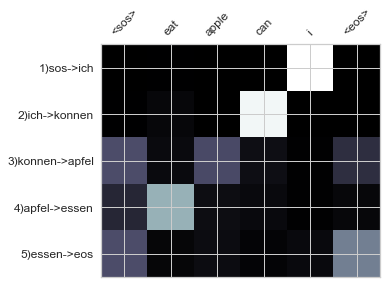

In [34]:
_ = test_sentence("eat apple can i",attention_type=ATTENTION_DEFAULT,draw_charts=True)

source = ['i', 'can', 'eat', 'apple']
predicted target = ['ich', 'konnen', 'apfel', 'essen', '<eos>']
Logits


,unk,pad,sos,eos,ich,wir,essen,konnen,lesen,mochten,trinken,apfel,bier,brot,buch,wasser,zeitung
1)sos->ich,-1.11,-1.75,0.26,-1.54,8.07,-0.30,0.43,-2.10,-0.15,-0.94,-0.07,-0.65,-1.77,-0.76,-0.69,-0.12,-0.46
2)ich->konnen,-1.12,-0.65,-0.44,-1.01,-2.78,-1.08,-0.18,7.60,1.02,0.94,0.42,0.39,-0.57,-0.10,-2.47,-1.32,-2.68
3)konnen->apfel,-1.35,-1.88,-0.77,0.79,-1.39,-2.06,0.20,0.24,-0.25,-4.33,-0.76,6.14,1.96,1.75,0.08,0.67,-2.01
4)apfel->essen,-1.16,-1.92,-0.62,1.88,-0.09,-1.13,7.39,-0.94,-1.68,-3.27,-0.57,0.11,-0.02,-0.21,-1.14,-1.03,-3.51
5)essen->eos,-0.59,-2.58,-1.20,5.64,-1.01,-0.99,-0.56,-0.85,-0.25,-4.56,-0.13,4.88,1.02,2.60,-0.36,-1.22,-1.43


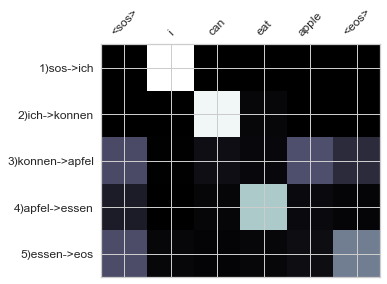

In [35]:
_ = test_sentence("i can eat apple",attention_type=ATTENTION_DEFAULT,draw_charts=True)
#at konnen -> attention is at apfel
#at apfel attention is at eat

source = ['i', 'want', 'to', 'eat', 'apple']
predicted target = ['ich', 'essen', 'apfel', 'essen', '<eos>']
Logits


,unk,pad,sos,eos,ich,wir,essen,konnen,lesen,mochten,trinken,apfel,bier,brot,buch,wasser,zeitung
1)sos->ich,-2.07,-1.43,-0.29,-2.10,5.30,3.40,-0.28,-0.40,-0.58,-1.71,-0.41,2.28,-1.98,-0.92,-0.97,-1.81,-3.23
2)ich->essen,-0.59,-1.42,-2.45,-3.78,0.17,-0.40,2.69,1.70,1.66,1.97,2.36,0.74,-0.90,-0.95,-1.18,-2.05,-4.82
3)essen->apfel,-0.82,-3.37,-2.54,2.20,-0.71,-0.79,1.36,-0.80,-0.25,-1.08,1.51,2.66,0.85,1.33,0.33,-0.14,-3.52
4)apfel->essen,-2.18,-3.75,-0.05,1.89,1.10,-0.88,5.39,-1.02,0.44,-2.43,0.28,0.41,-0.02,-1.08,-1.02,-0.64,-2.80
5)essen->eos,-0.58,-3.28,-2.26,3.95,-0.73,-1.04,1.46,-1.01,-0.50,-2.12,0.95,2.90,1.36,1.92,0.50,-0.40,-2.94


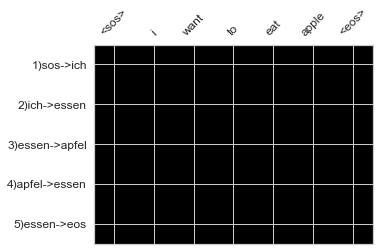

In [36]:
_ = test_sentence("i want to eat apple",attention_type=ATTENTION_EQUAL_DISTRIBUTED,draw_charts=True)
#since no real attention network cannot predict well

In [37]:
#utility class for future visualizations
class DebugStepWord:
    def __init__(self,sentence,translation):
        self.q = None
        self.k = None
        self.v = None
        self.energy = None
        self.attention = None
        self.mask = None
        self.x1 = None
        self.sentence = sentence
        self.translation = translation
        self.original_embedding = None 
        self.word_vector = None #only filled if done at world level
        self.word_translation = None #only filled if done at world level
        self.word_embeddding  = None #only filled if done at world level
        
    def summary(self):
        print("q",self.q.shape)
        print("k",self.k.shape)
        print("v",self.v.shape)
        print("attention",self.attention.shape)
        print("energy",self.energy.shape)
        print("mask",self.mask.shape)
        print("x1",self.x1.shape)
        print("x1",self.x1.shape)
        print("word_translation",self.word_translation)
        print("translation",self.translation)


In [38]:
#for all sentences generate a map
all_sentences = {}
for i, batch in enumerate(train_iterator):
    src = batch.src
    trg = batch.trg
    for i in range( (src.shape[0]) ):
        #print( encoding_to_sentence(src[i],SRC) ,encoding_to_sentence(trg[i],TRG)  )
        all_sentences[" ".join(encoding_to_sentence(src[i],SRC)) ] = " ".join(encoding_to_sentence(trg[i],TRG) )

def find_src_sentence_from_trg(trg_sentence):
    for src in all_sentences.keys():
        if all_sentences[src].find( trg_sentence) >= 0:
            return src
    assert 1 == 2 #must not reach here
    
#last word is trimmed so here find full version of sentence    
def find_fullsentence_from_trg(trg_sentence):
    for src in all_sentences.keys():
        if all_sentences[src].find( trg_sentence) >= 0:
            return all_sentences[src]
    assert 1 == 2    
#assert find_src_sentence("ich essen apfel")    == "<sos> i eat bread <eos> <pad> <pad>"
#print(find_src_sentence_from_trg("ich essen apfel"))
#print(find_fullsentence_from_trg("ich essen apfel"))
assert find_fullsentence_from_trg("ich essen apfel") == "<sos> ich essen apfel <eos> <pad>"
#assert "<sos> i eat bread <eos> <pad> <pad>" ==  find_src_sentence_from_trg("ich essen apfel")

In [39]:
#all_sentences  open here if u want to see the map

In [40]:
#prepare intermediate vector maps
steps_decoder_bysentence = []
LANG = TRG
last_sentence_encoding_batch = None
last_sentence_original_batch = None
for i in range(len(data_pipeline)):
    #print( data_pipeline[i][0] )
    current_label = data_pipeline[i][0]
    if "decoder_encoder_attention@QKV" == current_label: # TODO encoder@QKV
         #cnt += 1
         #print("i",i)
         sentence_batch = last_sentence_encoding_batch
         batch_len = sentence_batch.shape[0]   
         #assert batch_len == len(data_pipeline[i][1] )
         #for zip_index,data_tuple in enumerate(zip(last_sentence_batch,data_pipeline[i][1])):
         for sent_index in range(batch_len):  
            sentence = sentence_batch[sent_index]
            data_part = data_pipeline[i][1]
            original_embedding = last_sentence_original_batch[sent_index]
            translation = " ".join( encoding_to_sentence(original_embedding,TRG) )
            dstep = DebugStepWord(sentence,translation)
            dstep.original_embedding = original_embedding 
            dstep.q = data_pipeline[i][1][0][sent_index].squeeze().detach()
            dstep.k = data_pipeline[i][1][1][sent_index].squeeze().detach()
            dstep.v = data_pipeline[i][1][2][sent_index].squeeze().detach()
            dstep.energy = data_pipeline[i][1][4][sent_index].squeeze().detach()
            dstep.attention = data_pipeline[i][1][5][sent_index].squeeze().detach()
            dstep.mask = data_pipeline[i][1][6][sent_index].squeeze().detach()
            dstep.x1 = data_pipeline[i][1][7][sent_index].squeeze().detach()
            steps_decoder_bysentence.append(dstep)
    if "Decoder->encoder_attention" == current_label: #TODO Encoder->attention
         #print("i",i)
         last_sentence_encoding_batch = data_pipeline[i][1]
    if "Decoder_original->trg" == current_label: #TODO Encoder->attention
         #print("i",i)
         last_sentence_original_batch = data_pipeline[i][1]    
         
         #Ss.append(data_pipeline[i][1])

In [41]:
assert N_EPOCHS * len(steps_decoder_bysentence) * 36
print( " epochs: ",N_EPOCHS , " log length : ", len(steps_decoder_bysentence) )
# num epoch x 36 sentence  

 epochs:  30  log length :  1080


In [42]:
assert steps_decoder_bysentence[0].v.shape[0] == 7
assert steps_decoder_bysentence[0].v.shape[1] == HID_DIM 


In [43]:
steps_decoder_byword = []
for step in steps_decoder_bysentence:
    word_count = step.q.shape[0]
    for i in range(word_count):        
        word_step = DebugStepWord(step.sentence,step.translation)    
        #print("step.q",step.q.shape)
        word_step.q = step.q[i]
        word_step.k = step.k[i]
        word_step.v = step.v[i]
        word_step.energy = step.energy[i]
        word_step.attention = step.attention[i]
        word_step.mask = step.mask[i]
        word_step.x1 = step.x1[i]
        word_step.sentence = step.sentence
        word_step.translation = step.translation
        word_step.word_vector = step.sentence[i]
        word_step.word_embeddding = step.original_embedding[i]
        #print("step.sentence.squeeze()[i]",word_step.word_embeddding )
        word_step.word_translation = encoding_to_word(word_step.word_embeddding,LANG)
        steps_decoder_byword.append( word_step )

assert steps_decoder_byword[0].q.shape[0] == 64 #indexes must be single dimension
assert steps_decoder_byword[0].word_vector.shape[0] == 64 #indexes must be single dimension

In [44]:
def get_by_sentence(search_sentence,steps):
    return [ step for step in steps if step.translation.find(search_sentence) >=0 ]
    
def get_by_word(search_sentence,keywords,steps_word):
    steps_for_sample = get_by_sentence(search_sentence,steps_word)
    keyword_map = {}
    for step in steps_for_sample :
        if step.word_translation in keywords :
            if step.word_translation in keyword_map.keys():
                keyword_map[step.word_translation] = keyword_map[step.word_translation]+[step]
            else:    
                keyword_map[step.word_translation] = [step]
            
    return keyword_map
       

In [45]:
#for a target sentence(german) find intermediate steps
def steps_for_target(search_sentence):
    steps_for_sample = get_by_sentence(search_sentence,steps_decoder_bysentence)
    for index,step in enumerate(steps_for_sample):
        if index == 0 or (index+1) % 10 == 0:
            print("training epoch :",index+1)
            attention = step.attention.detach().numpy()
            splits = step.translation.split(" ")
            splits = [s.replace("<","").replace(">","") for s in splits]
            
            splits = [ splits[i]+"->"+splits[i+1]  for i in range(len(splits)-1)] + [splits[len(splits)-1]+"->eos"]            
            splits = [ str(index+1)+")"+s for index,s in enumerate(splits)]
            
            src_sentence_splits = find_src_sentence_from_trg(step.translation).split(" ")
            src_sentence_splits = [s.replace("<","").replace(">","").replace("pad","pad"+str(index)) for index,s in enumerate(src_sentence_splits)]            
            draw_df(np.array(attention),columns=src_sentence_splits,indexes=splits)

In [46]:
#steps_for_target("wir essen apfel")
#steps_for_target("wir mochten apfel essen")
steps_for_target("wir konnen apfel essen")

training epoch : 1


,sos,we,can,eat,apple,eos,pad6
1)sos->wir,0.74,0.03,0.02,0.14,0.06,0.02,0.00
2)wir->konnen,0.06,0.15,0.08,0.39,0.27,0.05,0.00
3)konnen->apfel,0.71,0.02,0.04,0.12,0.07,0.05,0.00
4)apfel->essen,0.38,0.06,0.20,0.17,0.05,0.13,0.00
5)essen->eos,0.38,0.03,0.02,0.34,0.16,0.07,0.00


training epoch : 10


,sos,we,can,eat,apple,eos,pad6
1)sos->wir,0.02,0.65,0.07,0.11,0.07,0.07,0.00
2)wir->konnen,0.04,0.04,0.44,0.08,0.10,0.30,0.00
3)konnen->apfel,0.17,0.11,0.46,0.11,0.07,0.08,0.00
4)apfel->essen,0.76,0.03,0.14,0.04,0.01,0.02,0.00
5)essen->eos,0.82,0.00,0.06,0.05,0.02,0.04,0.00


training epoch : 20


,sos,we,can,eat,apple,eos,pad6
1)sos->wir,0.00,0.97,0.00,0.01,0.00,0.01,0.00
2)wir->konnen,0.01,0.02,0.93,0.03,0.01,0.00,0.00
3)konnen->apfel,0.35,0.27,0.05,0.07,0.13,0.12,0.00
4)apfel->essen,0.13,0.07,0.01,0.75,0.02,0.01,0.00
5)essen->eos,0.54,0.01,0.03,0.09,0.04,0.30,0.00


training epoch : 30


,sos,we,can,eat,apple,eos,pad6
1)sos->wir,0.00,0.88,0.04,0.05,0.01,0.02,0.00
2)wir->konnen,0.02,0.03,0.69,0.20,0.02,0.04,0.00
3)konnen->apfel,0.22,0.10,0.11,0.05,0.41,0.11,0.00
4)apfel->essen,0.21,0.01,0.01,0.66,0.05,0.06,0.00
5)essen->eos,0.53,0.01,0.04,0.07,0.13,0.23,0.00


In [47]:
#includes : list of vectors to add Q,K,V,A
#get steps for stated vectors
def map_word_by_sentence(steps_for_sample,includes="QV",ranks=[1,15,N_EPOCHS]):
    Xs = []
    Ys = []
    for key in steps_for_sample.keys():
        for index,step in enumerate(steps_for_sample[key]):
            #print("index:",index)            
            if "Q" in includes:
                Xs.append( step.q.numpy())
                Ys.append( key+"@Q@"+str(index+1) )
            if "K" in includes:
                Xs.append( step.k.numpy())
                Ys.append( key+"@K@"+str(index+1) )
            if "V" in includes:
                Xs.append( step.v.numpy())
                Ys.append( key+"@V@"+str(index+1) )
            if "X" in includes:
                Xs.append( step.x1.numpy())
                Ys.append( key+"@X1@"+str(index+1) )     
    return filter_by_indexes(Xs,Ys,ranks)

def filter_by_indexes(Xs,Ys,ranks):
    Xnew = []
    Ynew = []
    for val,key in zip(Xs,Ys):        
        item_rank = key.split("@")[2]
        if int(item_rank) in ranks:
            Xnew.append(val)
            Ynew.append(key)
    return Xnew,Ynew    

def filter_by_key(Xs,Ys,keys):
    X_new,Y_new = [],[]
    for val,key in zip(Xs,Ys):
        if key.split("@")[0] in keys:
            X_new.append(val)
            Y_new.append(key)
    return X_new,Y_new        

def get_as_map(Xs,Ys,map_keys):
    xy_map = {}
    for val,key in zip(Xs,Ys):
        if key in map_keys:
            xy_map[key]=val
    return xy_map       


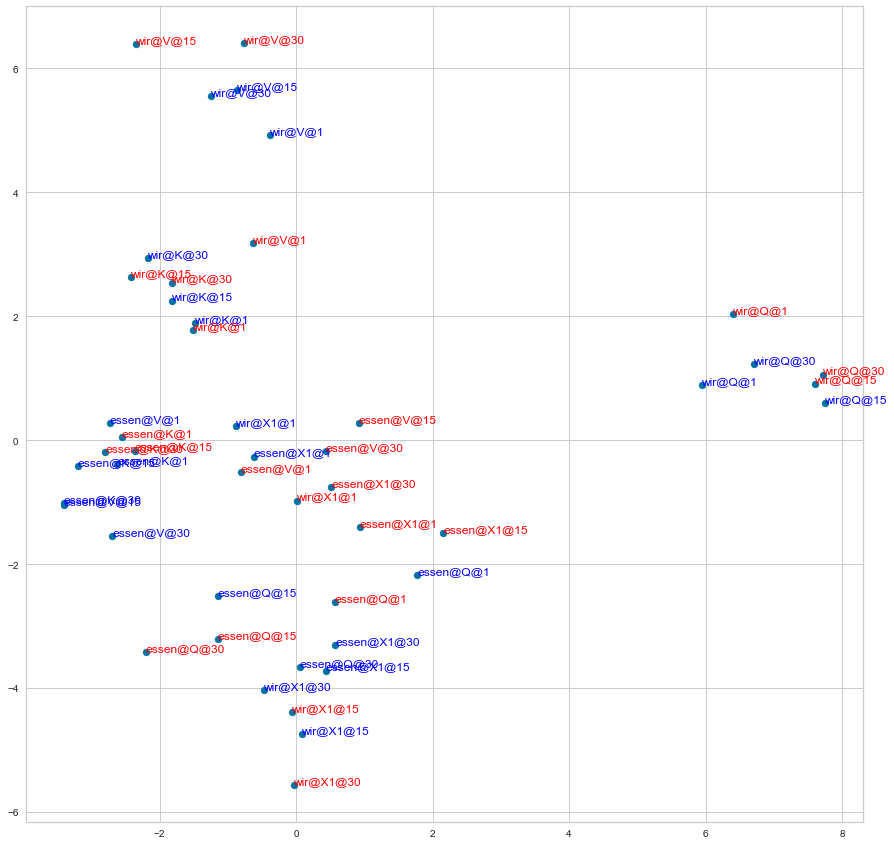

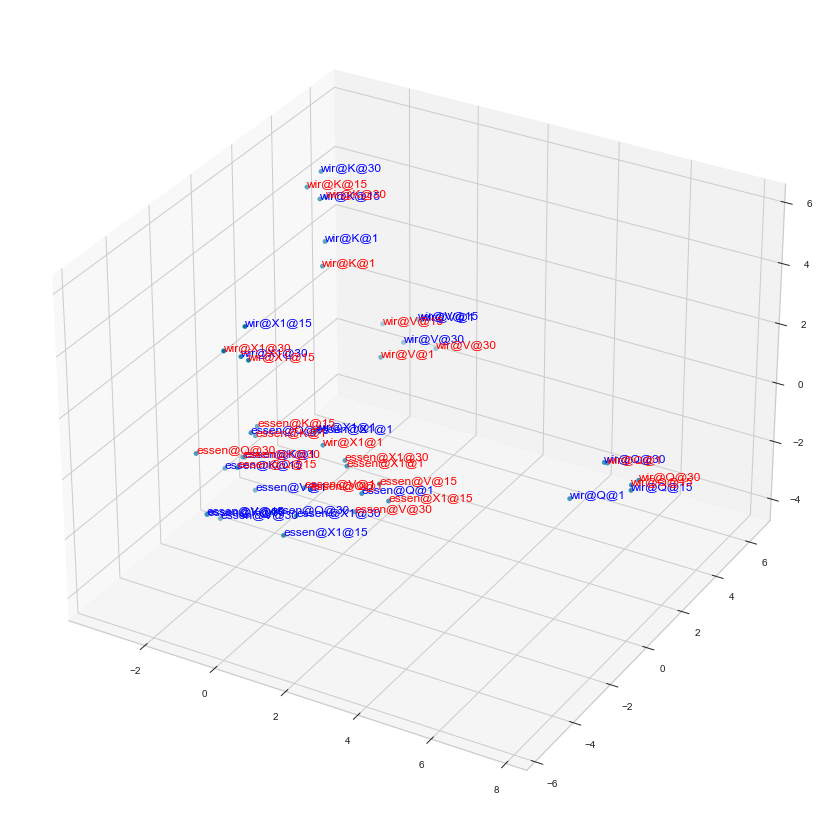

In [48]:
#altough wir and essen are same words, their embedding changed over time
#mapping on 2d changes over time, and network learns to differentiate better on final encoding
#final encoding is on 30th step. Here mapping is with wir and essen
search_sentence = "wir konnen apfel essen"
steps_for_sample = get_by_word(search_sentence,["essen","wir"],steps_decoder_byword)
X_s1,Y_s1 = map_word_by_sentence(steps_for_sample,includes="QKVX",ranks=[1,15,30])

search_sentence2 = "wir konnen brot essen"
steps_for_sample2 = get_by_word(search_sentence2,["essen","wir"],steps_decoder_byword)
X_s2,Y_s2 = map_word_by_sentence(steps_for_sample2,includes="QKVX",ranks=[1,15,30])

Xs = X_s1 + X_s2
Ys = [ s for s in Y_s1] + [ s for s in Y_s2]
color_mapping = [ "#0000ff" for s in Y_s1] + [ "#ff0000" for s in Y_s2]


pca = PCA(n_components=2)
X_transformed = pca.fit_transform(np.array(Xs))
map_on_2d(np.array(X_transformed),Ys,color_mapping=color_mapping,use_word_colors=False,fig_size=[15,15]) 

pca = PCA(n_components=3)
X_transformed = pca.fit_transform(np.array(Xs))
map_on_3d(np.array(X_transformed),Ys,color_mapping=color_mapping,use_word_colors=False,fig_size=[15,15]) 

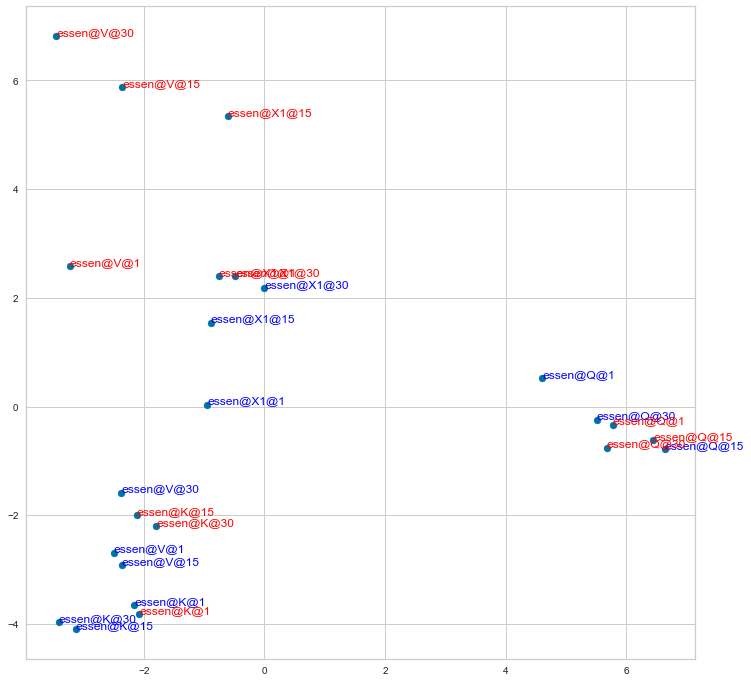

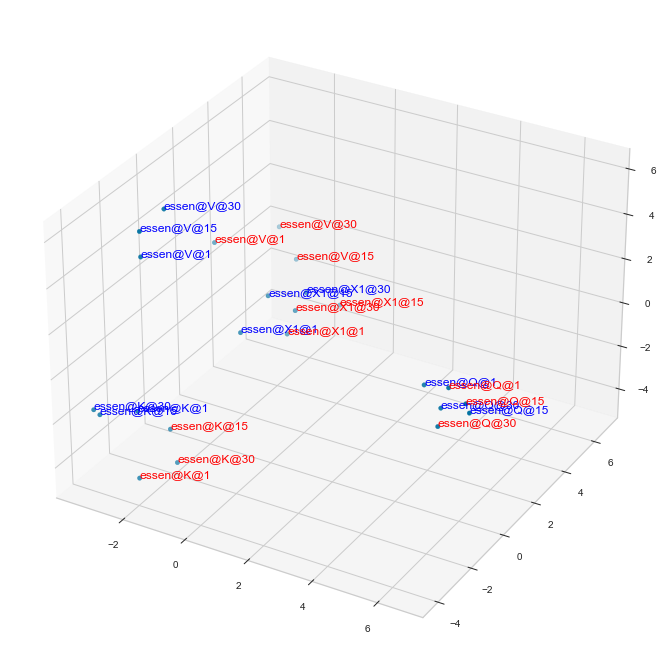

In [49]:
#show only essen
search_sentence = "wir konnen apfel essen"
steps_for_sample = get_by_word(search_sentence,["essen"],steps_decoder_byword)
X_s1,Y_s1 = map_word_by_sentence(steps_for_sample,includes="QKVX",ranks=[1,15,30])

search_sentence2 = "wir konnen brot essen"
steps_for_sample2 = get_by_word(search_sentence2,["essen"],steps_decoder_byword)
X_s2,Y_s2 = map_word_by_sentence(steps_for_sample2,includes="QKVX",ranks=[1,15,30])

Xs = X_s1 + X_s2
Ys = [ s for s in Y_s1] + [ s for s in Y_s2]
color_mapping = [ "#0000ff" for s in Y_s1] + [ "#ff0000" for s in Y_s2]

pca = PCA(n_components=2)
X_transformed = pca.fit_transform(np.array(Xs))
map_on_2d(np.array(X_transformed),Ys,color_mapping=color_mapping,use_word_colors=False,fig_size=[12,12]) 

pca = PCA(n_components=3)
X_transformed = pca.fit_transform(np.array(Xs))
map_on_3d(np.array(X_transformed),Ys,color_mapping=color_mapping,use_word_colors=False,fig_size=[12,12]) 

In [50]:
#get embeddings of all valid sentences for DecoderLayer@trg4
valid_sentences = [ " ".join( tabular_set[i].src) for i in range(len(tabular_set)) ]
    
valid_sentences_embeddings = []
for i in range(len(tabular_set)):
    test_logger,all_outputs,_ = test_sentence(tabular_set[i].src,draw_charts=False,dump_result=False)
    trg4 = test_logger.get_summary(labels=["DecoderLayer@trg4"],show_data=False)
    valid_sentences_embeddings.append(trg4[0].numpy().flatten())
    
#get embeddings of all applied equal attention sentences for DecoderLayer@trg4
invalid_sentences_embeddings = []
for i in range(len(tabular_set)):
    test_logger,all_outputs,_ = test_sentence(tabular_set[i].src,draw_charts=False,attention_type=2,dump_result=False)    
    trg4 = test_logger.get_summary(labels=["DecoderLayer@trg4"],show_data=False)

    invalid_sentences_embeddings.append(trg4[0].numpy().flatten())    

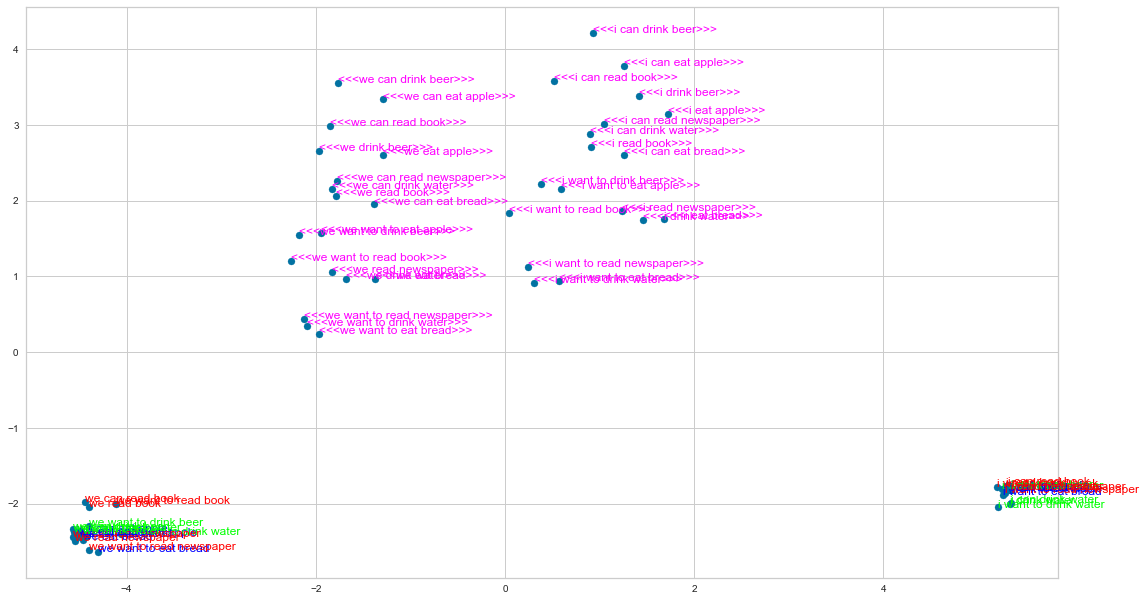

In [51]:
show_on_vis_multi(invalid_sentences_embeddings,valid_sentences,valid_sentences_embeddings,valid_sentences)


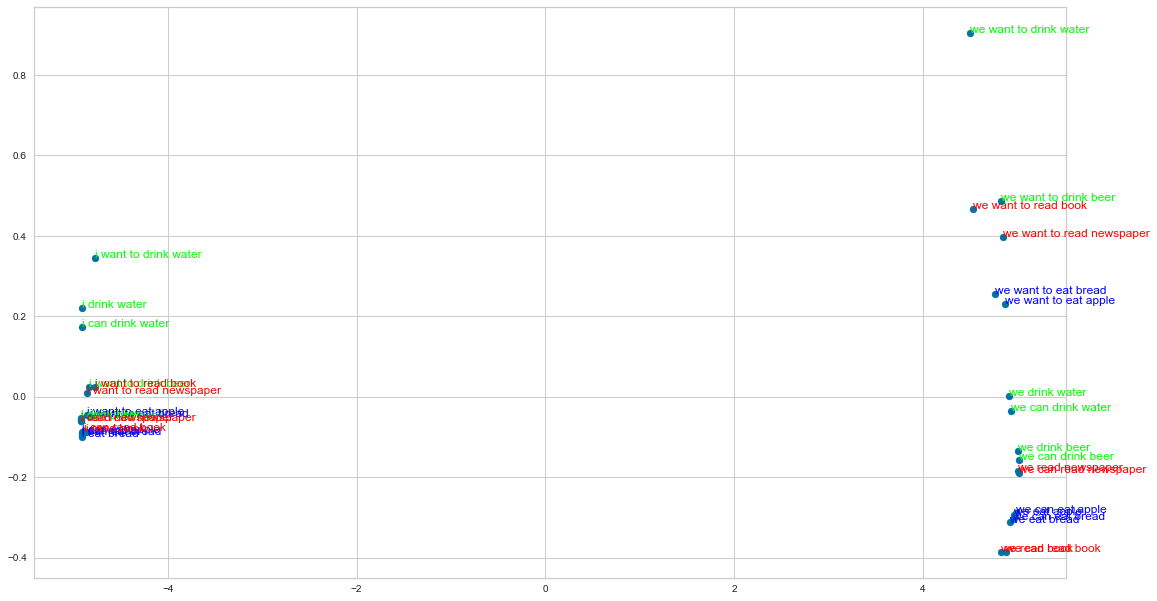

In [52]:
show_on_vis_multi([],[],valid_sentences_embeddings,valid_sentences)

pos_type :  APPLY_EVERYTHING
source = ['we', 'want', 'to', 'eat', 'apple']
predicted target = ['wir', 'mochten', 'apfel', 'essen', '<eos>']
Logits


,unk,pad,sos,eos,ich,wir,essen,konnen,lesen,mochten,trinken,apfel,bier,brot,buch,wasser,zeitung
1)sos->wir,-2.63,-0.33,-1.49,-1.92,1.71,7.72,-0.73,-0.68,0.11,1.45,-0.17,-1.32,-1.47,-0.92,0.40,-0.45,-1.11
2)wir->mochten,0.51,-0.29,-2.67,-2.27,-0.09,1.93,0.42,1.35,0.52,8.21,2.10,-4.25,-0.54,-1.53,-1.97,-1.15,0.53
3)mochten->apfel,-1.04,-0.49,-0.70,0.50,-1.63,-0.81,-0.33,-0.67,-0.87,-4.51,-1.57,6.17,2.39,1.84,1.11,0.76,-0.34
4)apfel->essen,-1.27,-1.98,-0.76,2.04,-0.18,-0.98,7.58,-1.29,-1.74,-2.96,-0.27,-0.57,-0.02,-0.32,-1.09,-0.81,-3.22
5)essen->eos,-0.56,-2.82,-1.33,5.89,-1.31,-1.13,-0.75,-1.51,-0.25,-4.51,0.26,4.41,1.16,2.52,-0.15,-0.75,-1.25


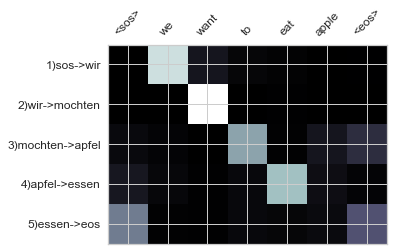

pos_type :  APPLY_ONLY_TARGET_WITHOUT_SCALE
source = ['we', 'want', 'to', 'eat', 'apple']
predicted target = ['wir', 'mochten', 'apfel', 'essen', '<eos>']
Logits


,unk,pad,sos,eos,ich,wir,essen,konnen,lesen,mochten,trinken,apfel,bier,brot,buch,wasser,zeitung
1)sos->wir,-2.85,-0.79,-1.91,-1.53,1.40,7.22,-0.09,-1.07,0.20,0.67,0.13,-1.06,-1.58,-0.67,0.19,0.09,-1.60
2)wir->mochten,0.62,-0.89,-3.28,-1.96,-0.27,1.58,0.80,1.16,0.57,7.91,2.56,-4.13,-0.79,-1.32,-2.18,-1.01,0.12
3)mochten->apfel,-0.72,-0.58,-1.41,-1.01,-0.28,-1.02,0.84,-0.76,-0.37,-3.50,-1.29,5.04,1.63,0.66,0.39,1.72,-1.35
4)apfel->essen,-2.17,-3.90,-1.59,2.95,-0.89,-1.68,5.95,-1.42,-0.60,-4.19,0.88,0.88,-0.21,-0.18,-1.33,0.03,-2.94
5)essen->eos,-1.01,-3.64,-2.29,4.65,-1.62,-2.06,1.71,-1.48,-0.45,-4.30,1.38,3.48,0.70,1.72,-0.56,-0.11,-2.51


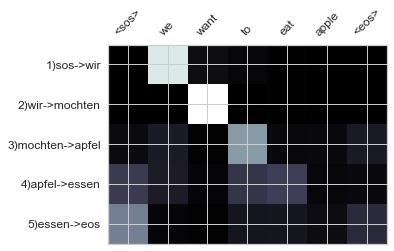

pos_type :  APPLY_ONLY_TARGET_EMBEDDING
source = ['we', 'want', 'to', 'eat', 'apple']
predicted target = ['wir', 'mochten', 'apfel', 'essen', '<eos>']
Logits


,unk,pad,sos,eos,ich,wir,essen,konnen,lesen,mochten,trinken,apfel,bier,brot,buch,wasser,zeitung
1)sos->wir,-2.85,-0.79,-1.91,-1.53,1.40,7.22,-0.09,-1.07,0.20,0.67,0.13,-1.06,-1.58,-0.67,0.19,0.09,-1.60
2)wir->mochten,0.62,-0.89,-3.28,-1.96,-0.27,1.58,0.80,1.16,0.57,7.91,2.56,-4.13,-0.79,-1.32,-2.18,-1.01,0.12
3)mochten->apfel,-0.72,-0.58,-1.41,-1.01,-0.28,-1.02,0.84,-0.76,-0.37,-3.50,-1.29,5.04,1.63,0.66,0.39,1.72,-1.35
4)apfel->essen,-2.17,-3.90,-1.59,2.95,-0.89,-1.68,5.95,-1.42,-0.60,-4.19,0.88,0.88,-0.21,-0.18,-1.33,0.03,-2.94
5)essen->eos,-1.01,-3.64,-2.29,4.65,-1.62,-2.06,1.71,-1.48,-0.45,-4.30,1.38,3.48,0.70,1.72,-0.56,-0.11,-2.51


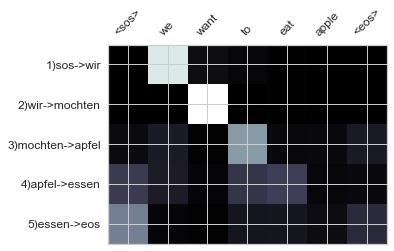

pos_type :  APPLY_ONLY_SOURCE_EMBEDDING
source = ['we', 'want', 'to', 'eat', 'apple']
predicted target = ['<eos>']
Logits


,unk,pad,sos,eos,ich,wir,essen,konnen,lesen,mochten,trinken,apfel,bier,brot,buch,wasser,zeitung
1)sos->eos,-2.37,-3.20,-0.42,3.87,-1.29,0.60,-2.19,-1.20,1.90,-2.98,1.32,1.94,-0.40,0.32,0.16,-0.25,-2.02


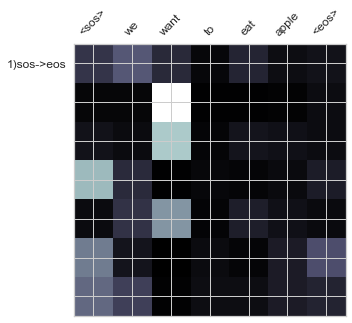

pos_type :  APPLY_ONLY_POS_EMBEDDING
source = ['we', 'want', 'to', 'eat', 'apple']
predicted target = ['mochten', 'essen', 'apfel', 'essen', '<eos>']
Logits


,unk,pad,sos,eos,ich,wir,essen,konnen,lesen,mochten,trinken,apfel,bier,brot,buch,wasser,zeitung
1)sos->mochten,-0.50,-2.52,-3.53,1.34,-0.79,1.61,1.48,-1.00,-0.70,4.63,2.30,-3.34,0.50,-1.07,-0.12,0.38,2.65
2)mochten->essen,-1.44,-2.50,-4.05,1.08,-1.69,-0.05,4.18,-0.90,-0.28,2.28,3.42,-3.56,0.35,-1.18,-1.45,-0.46,0.93
3)essen->apfel,-0.14,-1.71,-1.71,2.07,-1.74,-1.30,1.95,-0.53,-1.17,-3.18,1.82,4.64,1.03,0.54,-0.70,-0.30,-1.62
4)apfel->essen,-1.49,-3.00,-2.51,3.53,-1.19,0.79,4.67,-2.10,0.55,-2.01,1.13,-0.81,0.66,-1.08,-0.75,0.87,-1.95
5)essen->eos,-0.11,-3.53,-2.95,7.23,-1.71,-1.36,2.06,-1.45,-0.99,-2.85,1.23,1.24,1.88,1.53,-0.65,-0.80,0.56


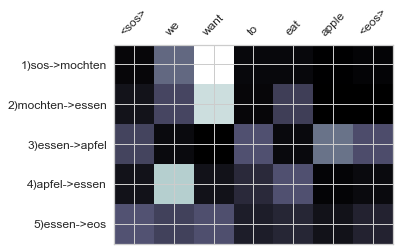

pos_type :  APPLY_ONLY_TARGET_WITH_SCALE
source = ['we', 'want', 'to', 'eat', 'apple']
predicted target = ['wir', 'mochten', 'apfel', 'essen', '<eos>']
Logits


,unk,pad,sos,eos,ich,wir,essen,konnen,lesen,mochten,trinken,apfel,bier,brot,buch,wasser,zeitung
1)sos->wir,-2.66,-0.30,-1.47,-1.87,1.69,7.70,-0.78,-0.68,0.17,1.28,-0.22,-1.21,-1.49,-0.87,0.38,-0.46,-1.23
2)wir->mochten,0.56,-0.31,-2.63,-2.23,0.02,2.10,0.30,1.34,0.52,8.19,2.05,-4.20,-0.61,-1.51,-1.98,-1.16,0.39
3)mochten->apfel,-1.13,-0.58,-0.80,0.52,-1.52,-0.81,-0.32,-0.68,-0.77,-4.57,-1.67,6.04,2.33,1.80,1.15,0.72,-0.36
4)apfel->essen,-1.37,-1.98,-0.71,2.07,-0.14,-0.99,7.53,-1.40,-1.91,-3.02,-0.19,-0.53,-0.06,-0.36,-1.06,-0.85,-3.20
5)essen->eos,-0.58,-2.78,-1.29,5.67,-1.37,-1.09,-0.78,-1.52,-0.29,-4.43,0.29,4.51,1.07,2.55,-0.21,-0.68,-1.37


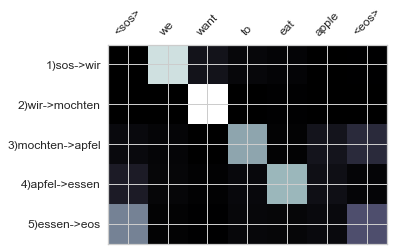

pos_type :  APPLY_NOT_ATTENTION
source = ['we', 'want', 'to', 'eat', 'apple']
predicted target = ['brot', '<sos>', 'apfel', 'essen', 'buch', 'zeitung', 'lesen', 'essen', 'buch', 'zeitung']
Logits


,unk,pad,sos,eos,ich,wir,essen,konnen,lesen,mochten,trinken,apfel,bier,brot,buch,wasser,zeitung
1)sos->brot,-2.72,-0.98,0.79,-0.12,1.21,-0.99,-2.02,1.62,-1.90,-2.65,-1.77,2.60,-0.65,2.63,-1.27,1.02,-2.91
2)brot->sos,1.53,1.19,2.16,-0.62,-0.85,1.49,1.21,-0.24,-1.19,0.23,1.26,-0.44,0.86,-0.66,-0.43,0.87,-3.29
3)->apfel,-2.67,-0.82,0.96,-0.05,0.88,-1.04,-1.94,1.50,-1.94,-2.60,-1.66,2.80,-0.32,2.68,-1.00,1.07,-2.74
4)apfel->essen,-1.85,-1.93,0.59,1.16,-0.79,-0.85,3.23,0.27,-0.08,-2.41,-0.51,-3.44,-0.07,-1.28,0.45,0.16,1.25
5)essen->buch,1.55,-1.97,0.21,1.86,-2.76,-1.58,2.14,1.37,-0.43,-0.81,0.08,-2.79,1.54,0.62,2.63,1.33,-0.28
6)buch->zeitung,-0.88,0.55,0.54,0.64,0.36,2.36,-1.34,1.59,0.54,0.76,-0.43,-1.98,-0.70,0.82,1.02,1.57,3.36
7)zeitung->lesen,0.23,-2.91,-1.95,1.00,0.99,2.07,0.41,-0.08,3.32,-0.27,-1.46,-1.65,-0.70,-2.22,2.30,1.13,1.41
8)lesen->essen,-2.79,-0.72,-1.33,-0.43,-1.70,-2.72,1.62,0.89,-0.85,-2.10,0.56,-1.74,-0.56,-0.39,-1.62,1.59,-1.22
9)essen->buch,1.32,-2.15,0.07,1.48,-2.75,-1.17,2.21,1.30,-0.42,-0.57,0.20,-2.77,1.42,0.30,2.80,1.58,-0.37
10)buch->zeitung,-0.74,0.52,0.81,0.75,0.37,2.31,-1.27,1.47,0.70,0.78,-0.73,-1.95,-0.34,0.91,0.99,2.01,3.73


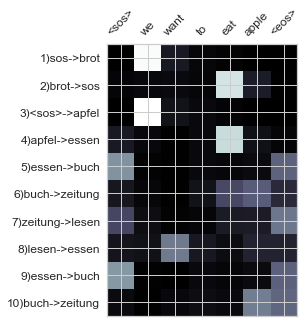

pos_type :  APPLY_NOT_DECODER_SELFATTENTION
source = ['we', 'want', 'to', 'eat', 'apple']
predicted target = ['wir', 'mochten', 'apfel', 'essen', '<eos>']
Logits


,unk,pad,sos,eos,ich,wir,essen,konnen,lesen,mochten,trinken,apfel,bier,brot,buch,wasser,zeitung
1)sos->wir,-2.91,-0.06,-1.05,0.07,0.86,6.96,-0.97,-0.86,0.10,0.11,-0.61,-0.33,-0.71,0.31,0.41,0.23,-0.92
2)wir->mochten,0.71,-0.22,-2.48,-0.85,-0.19,2.24,0.16,1.02,0.02,7.84,1.44,-3.96,-0.57,-0.84,-1.55,-1.68,1.39
3)mochten->apfel,-0.68,0.81,0.49,-0.90,0.87,-0.09,-0.54,-0.97,-0.36,-3.20,-2.53,5.27,1.73,0.60,0.78,0.65,-0.93
4)apfel->essen,-2.46,-3.42,0.33,3.84,-0.19,-0.71,5.13,-1.91,-0.72,-4.37,-0.40,0.61,0.28,-0.63,-0.29,-0.72,-1.93
5)essen->eos,-1.19,-3.20,-1.29,4.65,-1.50,-1.44,0.96,-1.63,-0.49,-3.90,0.87,3.40,0.98,1.56,0.15,-0.49,-2.19


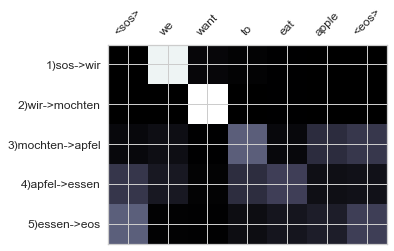

pos_type :  APPLY_ONLY_NORM_DECODER_SELFATTENTION
source = ['we', 'want', 'to', 'eat', 'apple']
predicted target = ['ich', 'mochten', 'wasser', 'trinken', '<eos>']
Logits


,unk,pad,sos,eos,ich,wir,essen,konnen,lesen,mochten,trinken,apfel,bier,brot,buch,wasser,zeitung
1)sos->ich,-2.17,-1.35,0.02,-2.69,5.30,3.97,-1.44,-0.04,-0.30,-0.19,-0.27,0.50,-2.75,-0.30,-1.51,-1.95,-1.23
2)ich->mochten,-0.66,-0.97,-2.25,-4.18,-1.68,-1.08,1.49,2.25,2.24,4.39,2.52,-1.35,-0.32,-0.02,-2.28,-1.33,-2.45
3)mochten->wasser,-0.79,-0.57,-0.47,-0.03,-1.18,-1.91,-1.19,-1.76,-1.51,-3.16,-1.84,2.70,2.73,2.05,2.76,2.98,2.59
4)wasser->trinken,-1.77,-0.83,-1.71,-0.86,-0.77,-1.24,0.30,-0.37,-0.46,1.25,4.73,-2.50,-2.87,-0.41,-2.81,-2.23,-1.71
5)trinken->eos,-0.71,-2.82,-1.50,5.36,-1.89,-1.62,0.75,-1.82,-0.95,-4.79,-0.24,1.40,2.55,0.65,2.15,1.12,1.18


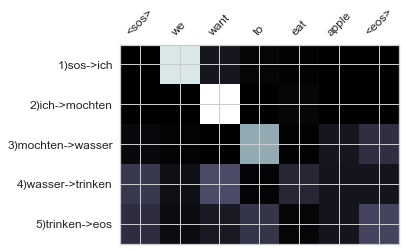

pos_type :  APPLY_ONLY_DECODER_SELFATTENTION
source = ['we', 'want', 'to', 'eat', 'apple']
predicted target = ['ich', 'mochten', 'wasser', 'trinken', '<eos>']
Logits


,unk,pad,sos,eos,ich,wir,essen,konnen,lesen,mochten,trinken,apfel,bier,brot,buch,wasser,zeitung
1)sos->ich,-2.19,-1.36,0.04,-2.71,5.30,3.91,-1.44,-0.05,-0.30,-0.20,-0.27,0.47,-2.77,-0.32,-1.53,-1.90,-1.24
2)ich->mochten,-0.68,-0.96,-2.22,-4.19,-1.68,-1.10,1.49,2.23,2.22,4.37,2.50,-1.32,-0.32,-0.00,-2.30,-1.28,-2.44
3)mochten->wasser,-0.81,-0.59,-0.42,-0.07,-1.15,-1.93,-1.16,-1.76,-1.51,-3.18,-1.83,2.70,2.70,2.04,2.72,2.97,2.54
4)wasser->trinken,-1.78,-0.86,-1.69,-0.94,-0.78,-1.20,0.27,-0.35,-0.44,1.30,4.68,-2.49,-2.85,-0.42,-2.83,-2.19,-1.73
5)trinken->eos,-0.71,-2.81,-1.48,5.22,-1.91,-1.67,0.82,-1.83,-0.94,-4.81,-0.25,1.46,2.53,0.68,2.13,1.10,1.17


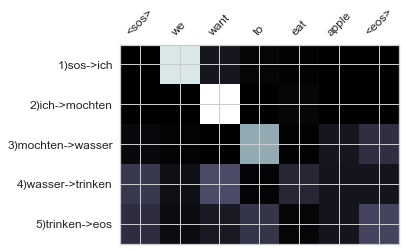

pos_type :  APPLY_ONLY_DROPOUT_DECODER_SELFATTENTION
source = ['we', 'want', 'to', 'eat', 'apple']
predicted target = ['wir', 'mochten', 'apfel', 'essen', 'apfel', 'apfel', 'apfel', 'apfel', 'apfel', 'apfel']
Logits


,unk,pad,sos,eos,ich,wir,essen,konnen,lesen,mochten,trinken,apfel,bier,brot,buch,wasser,zeitung
1)sos->wir,-2.05,-0.37,-2.03,1.24,-2.21,6.89,0.51,-1.76,0.39,1.67,0.30,-2.75,0.26,-0.60,1.56,0.73,0.49
2)wir->mochten,0.08,-0.47,-2.75,0.23,-0.42,2.85,-0.68,-0.12,-0.71,7.92,1.66,-4.24,0.18,-1.07,-1.20,-1.00,2.84
3)mochten->apfel,-1.28,-0.76,-0.19,1.51,-0.50,0.81,0.88,0.49,-0.66,-3.55,-0.62,5.29,0.86,0.76,-0.96,-2.00,-2.93
4)apfel->essen,-1.51,-1.40,-1.74,2.88,-0.50,-1.01,6.08,-1.14,-2.90,-3.34,-0.60,0.92,0.20,0.51,-0.81,-0.84,-3.84
5)essen->apfel,-1.28,-2.29,-0.80,4.04,-1.02,-1.41,0.32,-1.47,0.18,-5.25,0.85,5.07,0.60,0.97,-0.69,-1.50,-2.72
6)apfel->apfel,-1.35,-2.31,-0.99,4.29,-1.31,-1.05,0.56,-1.80,-0.14,-5.36,0.71,4.75,0.67,0.89,-0.37,-1.15,-2.74
7)apfel->apfel,-1.34,-2.32,-0.98,4.29,-1.29,-1.10,0.56,-1.79,-0.13,-5.35,0.72,4.77,0.66,0.90,-0.40,-1.17,-2.74
8)apfel->apfel,-1.37,-2.30,-1.02,4.31,-1.33,-1.06,0.76,-1.83,-0.26,-5.37,0.66,4.70,0.67,0.88,-0.38,-1.12,-2.83
9)apfel->apfel,-1.35,-2.29,-0.96,4.23,-1.27,-1.09,0.63,-1.77,-0.18,-5.37,0.68,4.79,0.67,0.89,-0.41,-1.17,-2.79
10)apfel->apfel,-1.36,-2.33,-1.02,4.34,-1.30,-1.12,0.70,-1.87,-0.25,-5.38,0.69,4.68,0.65,0.88,-0.38,-1.09,-2.77


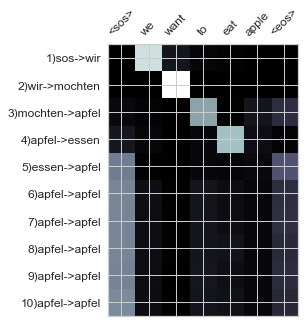

pos_type :  APPLY_NOT_POSITIONWISE
source = ['we', 'want', 'to', 'eat', 'apple']
predicted target = ['wir', 'mochten', 'apfel', 'essen', '<eos>']
Logits


,unk,pad,sos,eos,ich,wir,essen,konnen,lesen,mochten,trinken,apfel,bier,brot,buch,wasser,zeitung
1)sos->wir,-2.13,0.66,-1.19,-1.93,-0.36,5.19,-0.92,0.52,-0.89,1.02,0.23,-1.55,-0.93,-0.77,1.66,1.13,-1.36
2)wir->mochten,1.50,0.83,-1.63,-2.51,-0.53,0.98,-0.41,0.94,-0.00,6.49,1.56,-4.11,0.10,-1.65,0.66,0.65,2.04
3)mochten->apfel,-0.72,0.01,-0.44,0.21,-1.15,-0.59,-0.12,-1.37,-0.40,-4.02,-0.48,5.22,1.69,1.26,1.13,1.35,-1.53
4)apfel->essen,-0.34,-0.43,-1.20,0.02,-0.11,0.51,6.84,-0.36,-0.73,-2.88,-1.04,-1.16,0.39,-1.27,0.13,-0.24,-2.84
5)essen->eos,0.13,-1.63,-0.51,3.98,-1.57,-1.52,0.15,-0.88,1.14,-3.97,0.27,3.44,1.51,1.22,0.38,0.35,-2.80


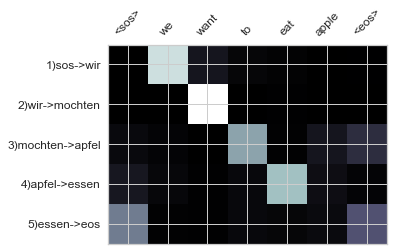

In [53]:
pos_types = [1,2,3,4,5,6,8,10,11,12,13,14]
apply_map = {}
apply_map[APPLY_EVERYTHING] = "APPLY_EVERYTHING"
apply_map[APPLY_NOT_DECODER_SELFATTENTION] = "APPLY_NOT_DECODER_SELFATTENTION"
apply_map[APPLY_ONLY_NORM_DECODER_SELFATTENTION] = "APPLY_ONLY_NORM_DECODER_SELFATTENTION"
apply_map[APPLY_ONLY_DECODER_SELFATTENTION] = "APPLY_ONLY_DECODER_SELFATTENTION"
apply_map[APPLY_ONLY_DROPOUT_DECODER_SELFATTENTION] = "APPLY_ONLY_DROPOUT_DECODER_SELFATTENTION"
apply_map[APPLY_NOT_POSITIONWISE] = "APPLY_NOT_POSITIONWISE"


apply_map[APPLY_ONLY_TARGET_WITHOUT_SCALE] = "APPLY_ONLY_TARGET_WITHOUT_SCALE"
apply_map[APPLY_ONLY_TARGET_EMBEDDING] = "APPLY_ONLY_TARGET_EMBEDDING"
apply_map[APPLY_ONLY_SOURCE_EMBEDDING] = "APPLY_ONLY_SOURCE_EMBEDDING"
apply_map[APPLY_ONLY_POS_EMBEDDING] = "APPLY_ONLY_POS_EMBEDDING"

apply_map[APPLY_ONLY_TARGET_WITH_SCALE] = "APPLY_ONLY_TARGET_WITH_SCALE"
apply_map[APPLY_NOT_ATTENTION] = "APPLY_NOT_ATTENTION"


#Open above to check all types enable/disable
for pos_type in pos_types:
    print("pos_type : ",apply_map[pos_type])
    _,_,_ = test_sentence("we want to eat apple",attention_type=1,draw_charts=True,pos_type=pos_type)

source = ['i', 'can', 'read', 'book']
predicted target = ['ich', 'konnen', 'buch', 'lesen', '<eos>']
Logits


,unk,pad,sos,eos,ich,wir,essen,konnen,lesen,mochten,trinken,apfel,bier,brot,buch,wasser,zeitung
1)sos->ich,-1.12,-1.85,0.15,-1.51,8.04,-0.27,0.33,-2.11,-0.05,-0.95,-0.02,-0.70,-1.68,-0.80,-0.59,-0.15,-0.48
2)ich->konnen,-1.09,-0.71,-0.47,-0.97,-2.81,-1.04,-0.54,7.65,1.28,1.01,0.54,0.24,-0.52,-0.16,-2.29,-1.38,-2.51
3)konnen->buch,-0.19,-2.27,-1.85,1.29,-1.17,0.96,-3.22,-0.41,1.57,-2.68,-1.61,-0.21,2.31,-0.85,6.33,-0.03,3.20
4)buch->lesen,-0.90,-4.12,-1.65,2.35,0.05,-0.21,-1.38,-0.74,6.99,-3.34,0.89,-0.23,0.77,-0.30,0.92,1.01,-1.37
5)lesen->eos,-1.04,-2.84,-1.71,6.69,-1.75,-0.87,-1.87,2.36,-0.20,-4.46,-0.75,-1.17,1.03,-0.97,3.12,-0.70,1.64


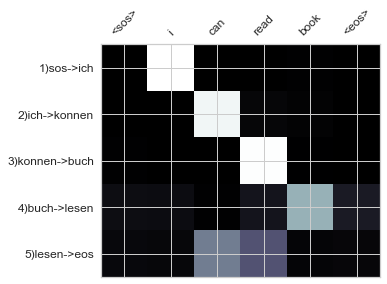

In [54]:
_ = test_sentence("i can read book",attention_type=ATTENTION_DEFAULT,draw_charts=True)
#Open to see other samples
#_ = test_sentence("i can read book",attention_type=ATTENTION_AT_END,draw_charts=True)
#_ = test_sentence("i want to read apple",attention_type=ATTENTION_DEFAULT,draw_charts=True)
#_ = test_sentence("i want to eat book",attention_type=ATTENTION_DEFAULT,draw_charts=True)
#_ = test_sentence("i can eat book",attention_type=ATTENTION_DEFAULT,draw_charts=True)
#attention_types = [1,2,3,4]
#for attention_type in attention_types:
#    _ = test_sentence("i can eat bread",attention_type=attention_type,draw_charts=True)
#_ = test_sentence("we beer can read",attention_type=1,draw_charts=True)

source = ['apple', 'eat', 'can', 'we']
predicted target = ['wir', 'konnen', 'apfel', 'essen', '<eos>']
Logits


,unk,pad,sos,eos,ich,wir,essen,konnen,lesen,mochten,trinken,apfel,bier,brot,buch,wasser,zeitung
1)sos->wir,-2.83,-0.41,-1.45,-1.69,1.58,7.58,-0.42,-0.74,0.12,0.83,-0.23,-1.14,-1.54,-0.86,0.41,-0.29,-1.55
2)wir->konnen,-0.60,-0.33,-0.27,-1.09,-1.27,-0.46,0.22,7.48,0.58,1.12,0.41,-0.50,-1.41,-0.85,-2.77,-1.30,-2.70
3)konnen->apfel,-1.31,-1.80,-0.77,1.04,-1.53,-1.93,0.06,-0.00,-0.24,-4.38,-0.72,6.06,2.10,1.71,0.19,0.82,-1.71
4)apfel->essen,-1.17,-1.86,-0.77,2.02,-0.35,-0.83,7.44,-0.91,-1.67,-3.19,-0.51,-0.21,-0.02,-0.24,-1.01,-0.94,-3.42
5)essen->eos,-0.60,-2.55,-1.20,5.70,-1.21,-0.88,-0.66,-0.86,-0.24,-4.56,-0.07,4.81,1.00,2.57,-0.35,-1.17,-1.37


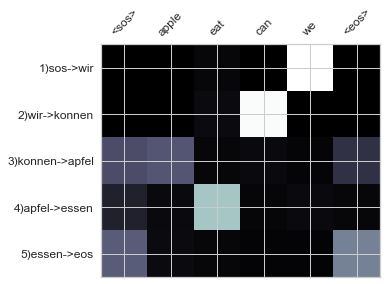

In [55]:
_ = test_sentence("apple eat can we",attention_type=ATTENTION_DEFAULT,draw_charts=True)
###!!! altough order is not correct network can correct it, but this is a bit overfitting
###and it wont happen if we use a big set.
#Open to see other samples
#_ = test_sentence("apple eat we can",attention_type=ATTENTION_DEFAULT,draw_charts=True)
#_ = test_sentence("apple eat can we",attention_type=1,draw_charts=True)

source = ['eat', 'drink', 'read', 'we', 'can']
predicted target = ['wir', 'konnen', 'buch', 'lesen', '<eos>']
Logits


,unk,pad,sos,eos,ich,wir,essen,konnen,lesen,mochten,trinken,apfel,bier,brot,buch,wasser,zeitung
1)sos->wir,-2.88,-0.57,-1.40,-1.57,1.96,7.49,-0.73,-0.85,0.13,0.72,-0.07,-1.34,-1.51,-1.13,0.55,-0.18,-1.52
2)wir->konnen,-0.56,-0.30,-0.40,-1.03,-1.24,-0.49,0.24,7.44,0.60,1.26,0.55,-0.76,-1.59,-0.96,-2.78,-1.08,-2.64
3)konnen->buch,-0.51,-2.15,-1.10,1.77,-1.02,1.05,-4.29,-1.30,1.63,-1.89,-0.25,-1.35,1.81,-1.77,5.78,2.02,4.15
4)buch->lesen,-0.81,-2.46,-1.82,2.20,-0.30,0.37,2.46,-0.52,3.33,-1.68,0.65,-2.65,0.87,-0.49,0.26,2.23,-2.11
5)lesen->eos,-1.00,-2.59,-1.43,6.81,-1.49,-0.82,-2.28,1.52,-0.46,-3.95,0.02,-1.97,0.70,-1.41,3.25,-0.02,2.18


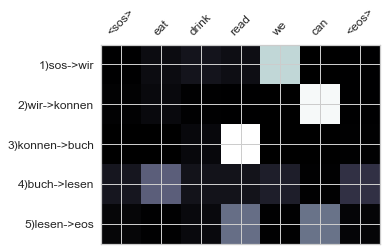

In [56]:
#when no object distinctive, if we put all verbs lesen is chosen over others.
_ = test_sentence("eat drink read we can",attention_type=ATTENTION_DEFAULT,draw_charts=True)


In [57]:
#show self attentions on encoder layer
#we have 36 sentences, change below values to see different sentence over training
for index in range(25,27):
    
    test_logger,all_outputs,_ = test_sentence(tabular_set[index].src,draw_charts=False,attention_type=1)
    encoded_attention = test_logger.get_summary(["EncoderLayer@sattention"],show_data=False)        
    
    output_words = ["sos"]+tabular_set[index].src  +["eos"]
    for head_index in range(encoded_attention[0].shape[1]):
        all_outputs0 = encoded_attention[0][:,head_index,:,:]
        draw_df(all_outputs0.squeeze().numpy(),output_words,output_words)

source = ['i', 'eat', 'apple']
predicted target = ['ich', 'essen', 'apfel', '<eos>']


,sos,i,eat,apple,eos
sos,0.04,0.29,0.09,0.13,0.44
i,0.76,0.10,0.13,0.00,0.01
eat,0.47,0.01,0.14,0.34,0.03
apple,0.00,0.00,0.00,0.99,0.00
eos,0.01,0.00,0.00,0.99,0.01


source = ['i', 'drink', 'water']
predicted target = ['ich', 'trinken', 'wasser', '<eos>']


,sos,i,drink,water,eos
sos,0.00,0.01,0.63,0.35,0.01
i,0.67,0.09,0.01,0.22,0.00
drink,0.07,0.01,0.01,0.89,0.02
water,0.01,0.06,0.10,0.81,0.02
eos,0.01,0.00,0.01,0.97,0.01


In [58]:
last_sentence_original_batch = None

In [59]:
steps_encoder_bysentence = []
LANG = SRC          #TOCHANGE
last_sentence_encoding_batch = None

for i in range(len(data_pipeline)):
    #print( data_pipeline[i][0] )
    current_label = data_pipeline[i][0]
    if "encoder@QKV" == current_label: # TODO  decoder_encoder_attention@QKV
         #cnt += 1
         #print("i",i)
         sentence_batch = last_sentence_original_batch
         batch_len = sentence_batch.shape[0]   
         #assert batch_len == len(data_pipeline[i][1] )         
         for sent_index in range(batch_len):  
            sentence = sentence_batch[sent_index]
            data_part = data_pipeline[i][1]
            original_embedding = last_sentence_original_batch[sent_index]
            translation = " ".join( encoding_to_sentence(original_embedding,LANG) )
            dstep = DebugStepWord(sentence,translation)
            dstep.original_embedding = original_embedding 
            dstep.q = data_pipeline[i][1][0][sent_index].squeeze().detach()
            dstep.k = data_pipeline[i][1][1][sent_index].squeeze().detach()
            dstep.v = data_pipeline[i][1][2][sent_index].squeeze().detach()
            dstep.energy = data_pipeline[i][1][4][sent_index].squeeze().detach()
            dstep.attention = data_pipeline[i][1][5][sent_index].squeeze().detach()
            dstep.mask = data_pipeline[i][1][6][sent_index].squeeze().detach()
            dstep.x1 = data_pipeline[i][1][7][sent_index].squeeze().detach()
            steps_encoder_bysentence.append(dstep)
    if "Encoder->attention" == current_label: #TODO  Decoder->attention
         #print("i",i)
         last_sentence_original_batch = data_pipeline[i][1]
    
             

In [60]:
assert list(steps_encoder_bysentence[0].q.shape) == [7,64]
assert N_EPOCHS * len(steps_encoder_bysentence) * 36
print( " epochs: ",N_EPOCHS , " log length : ", len(steps_encoder_bysentence) )
assert steps_encoder_bysentence[0].v.shape[0] == 7
assert steps_encoder_bysentence[0].v.shape[1] == HID_DIM 

 epochs:  30  log length :  1080


In [61]:
#collect stats by word
steps_encoder_byword = []
for step in steps_encoder_bysentence:
    word_count = step.q.shape[0]
    for i in range(word_count):        
        word_step = DebugStepWord(step.sentence,step.translation)    
        #print("step.q",step.q.shape)
        word_step.q = step.q[i]
        word_step.k = step.k[i]
        word_step.v = step.v[i]
        word_step.energy = step.energy[i]
        word_step.attention = step.attention[i]
        word_step.mask = step.mask[i]
        word_step.x1 = step.x1[i]
        word_step.sentence = step.sentence
        word_step.translation = step.translation
        word_step.word_vector = step.sentence[i]
        word_step.word_embeddding = step.original_embedding[i]
        #print("step.sentence.squeeze()[i]",word_step.word_embeddding )
        word_step.word_translation = encoding_to_word(word_step.word_embeddding,LANG)
        steps_encoder_byword.append( word_step )



In [62]:
assert steps_encoder_byword[0].q.shape[0] == 64 


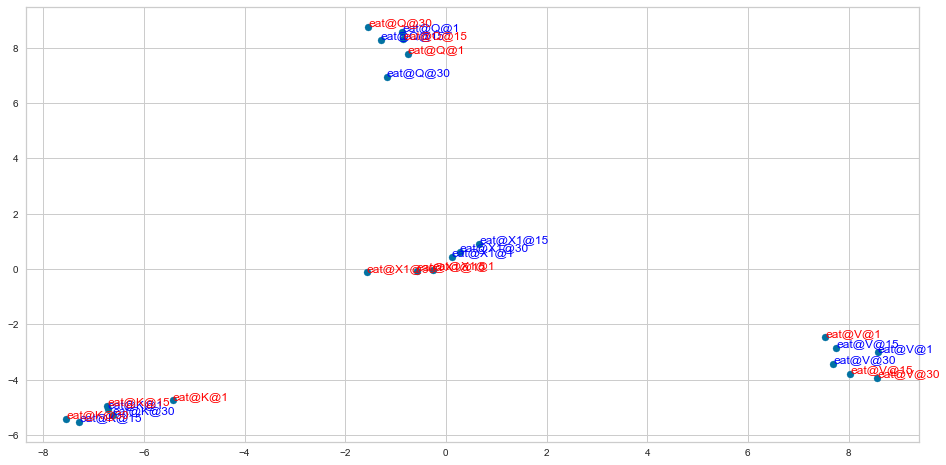

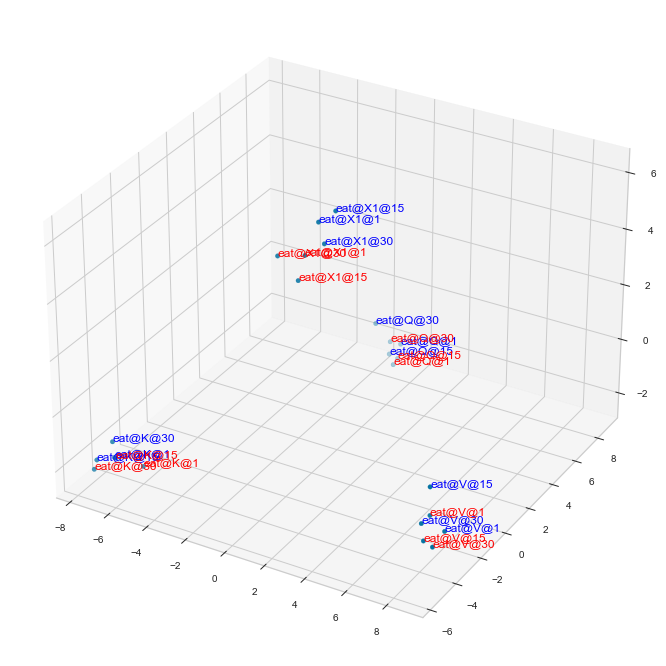

In [63]:
#altough "eat" and "we" are same their encodings differ in space, this sample
#has lets distinctive power than others
search_sentence = "we want to eat apple" #"eat","we","apple","want"
steps_for_sample = get_by_word(search_sentence,["eat"],steps_encoder_byword)
X_s1,Y_s1 = map_word_by_sentence(steps_for_sample,includes="QKVX",ranks=[1,15,30])

search_sentence2 = "we want to eat bread"
steps_for_sample2 = get_by_word(search_sentence2,["eat"],steps_encoder_byword)
X_s2,Y_s2 = map_word_by_sentence(steps_for_sample2,includes="QKVX",ranks=[1,15,30])

Xs = X_s1 + X_s2
Ys = [ s for s in Y_s1] + [ s for s in Y_s2]
color_mapping = [ "#0000ff" for s in Y_s1] + [ "#ff0000" for s in Y_s2]

pca = PCA(n_components=2)
X_transformed = pca.fit_transform(np.array(Xs))
map_on_2d(np.array(X_transformed),Ys,color_mapping=color_mapping,use_word_colors=False,fig_size=[16,8]) 

pca = PCA(n_components=3)
X_transformed = pca.fit_transform(np.array(Xs))
map_on_3d(np.array(X_transformed),Ys,color_mapping=color_mapping,use_word_colors=False,fig_size=[12,12]) 
###when we are checking encoder self attention, we see that q,v,k is less saturated,more clustered
#because no other source of input,or effect.

In [64]:
def collect_sentence_data(sentences,vector_name,indexes,keywords,use_last_vector=False,dump_result=False):
    print("vector_name",vector_name)
    Xs = []
    Ys = []
    for sentence_index,sentence in enumerate(sentences):
        test_logger,_,translation = test_sentence(sentence,attention_type=1,draw_charts=False,dump_result=dump_result)
        x4 = test_logger.get_summary([vector_name],show_data=False,summary_count=10)
        if use_last_vector:
            x4 = x4[len(x4)-1]
        
        for i,index in enumerate(indexes):
            #if use_last_vector it is decoder so we must use result from translation
            if use_last_vector:
                key = translation[index]
            else:    
                key = keywords[i]
            val = x4[0].squeeze()[index].numpy()
            Xs.append(val)
            Ys.append(key+"@"+str(sentence_index+1))
    return Xs,Ys

#dump vectors both on 2d and 3d
def dump_on_surface(Xs,Ys,dump_3d=True,dump_2d=False):
    colors =["#ff0000","#aa0000","#00ffdd","#0000ff","#ffaaaa"] 
    color_mapping = [ colors[ min(len(colors)-1, int(y.split("@")[1])) ] for y in Ys]
    #print(color_mapping)
                             
    if dump_3d:    
        pca = PCA(n_components=3)
        X_transformed = pca.fit_transform(np.array(Xs))
        map_on_3d(np.array(X_transformed),Ys,color_mapping=color_mapping,use_word_colors=False,fig_size=[10,10])
    if dump_2d:    
        pca = PCA(n_components=2)
        X_transformed = pca.fit_transform(np.array(Xs))
        map_on_2d(np.array(X_transformed),Ys,color_mapping=color_mapping,use_word_colors=False,fig_size=[10,10])
    


vector_name encoder@Q
source = ['i', 'can', 'eat', 'apple']
predicted target = ['ich', 'konnen', 'apfel', 'essen', '<eos>']
source = ['i', 'can', 'eat', 'bread']
predicted target = ['ich', 'konnen', 'brot', 'essen', '<eos>']
source = ['i', 'can', 'eat', 'book']
predicted target = ['ich', 'konnen', 'apfel', 'essen', '<eos>']
source = ['i', 'can', 'eat', 'newspaper']
predicted target = ['ich', 'konnen', 'brot', 'essen', '<eos>']
source = ['i', 'can', 'eat', 'apple', 'book']
predicted target = ['ich', 'konnen', 'apfel', 'essen', '<eos>']


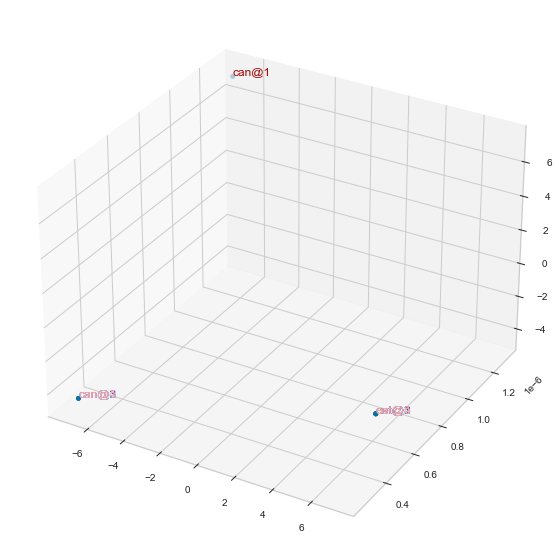

vector_name encoder@K


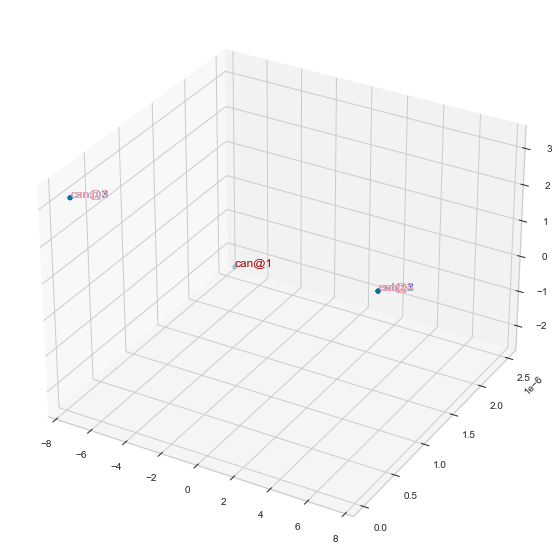

vector_name encoder@V


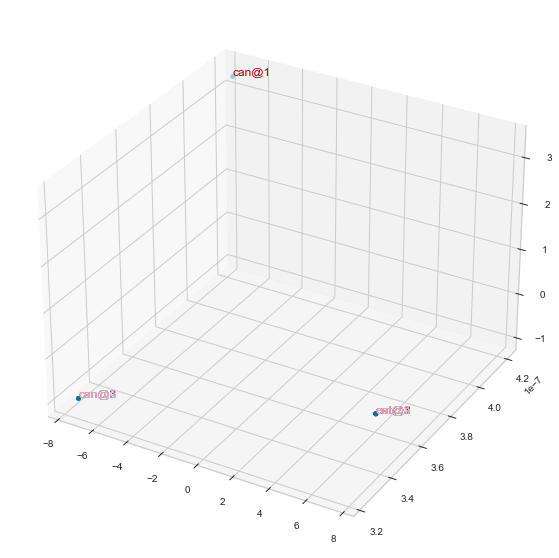

vector_name encoder@x1


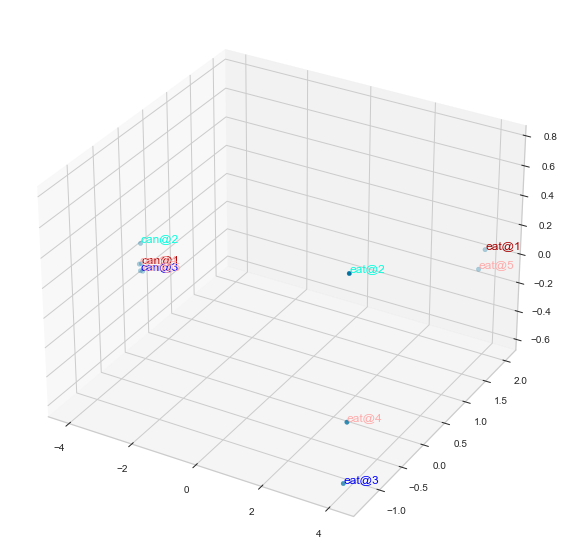

vector_name encoder@x4


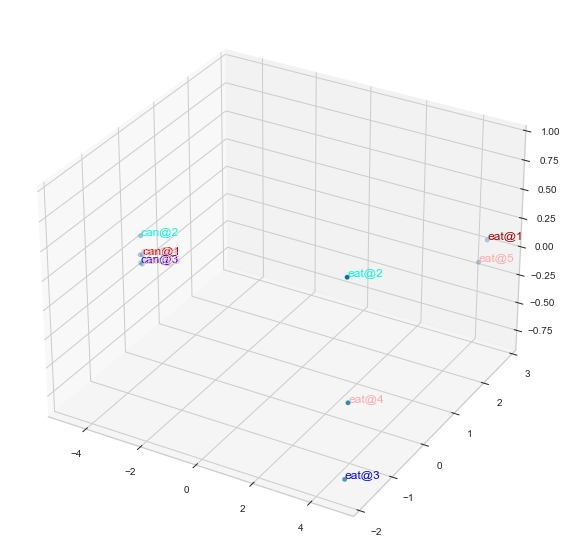

vector_name Encoder@src_final


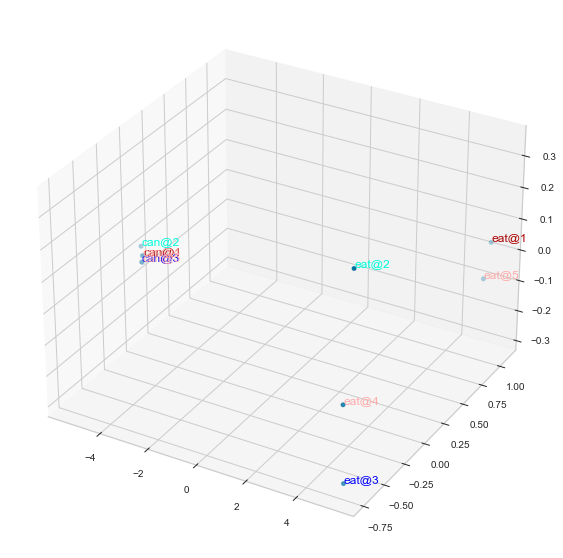

In [65]:
#For 5 sentences, focus on 2 words on dump their projection and see 
#how model generates different vectors for them     
test_sentences = ["i can eat apple","i can eat bread","i can eat book","i can eat newspaper","i can eat apple book"]

indexes = [2,3]
keywords = ["can","eat"]

Xs,Ys = collect_sentence_data(test_sentences,"encoder@Q",indexes,keywords,dump_result=True)
dump_on_surface( Xs,Ys )
Xs,Ys = collect_sentence_data(test_sentences,"encoder@K",indexes,keywords)
dump_on_surface( Xs,Ys )
Xs,Ys = collect_sentence_data(test_sentences,"encoder@V",indexes,keywords)
dump_on_surface( Xs,Ys )
Xs,Ys = collect_sentence_data(test_sentences,"encoder@x1",indexes,keywords)
dump_on_surface( Xs,Ys )
Xs,Ys = collect_sentence_data(test_sentences,"encoder@x4",indexes,keywords)
dump_on_surface( Xs,Ys )

Xs,Ys = collect_sentence_data(test_sentences,"Encoder@src_final",indexes,keywords)
dump_on_surface( Xs,Ys )


vector_name decoder_encoder_attention@Q
source = ['i', 'can', 'eat', 'apple']
predicted target = ['ich', 'konnen', 'apfel', 'essen', '<eos>']
source = ['i', 'can', 'eat', 'bread']
predicted target = ['ich', 'konnen', 'brot', 'essen', '<eos>']
source = ['i', 'can', 'eat', 'book']
predicted target = ['ich', 'konnen', 'apfel', 'essen', '<eos>']
source = ['i', 'can', 'eat', 'newspaper']
predicted target = ['ich', 'konnen', 'brot', 'essen', '<eos>']
source = ['i', 'can', 'eat', 'apple', 'book']
predicted target = ['ich', 'konnen', 'apfel', 'essen', '<eos>']


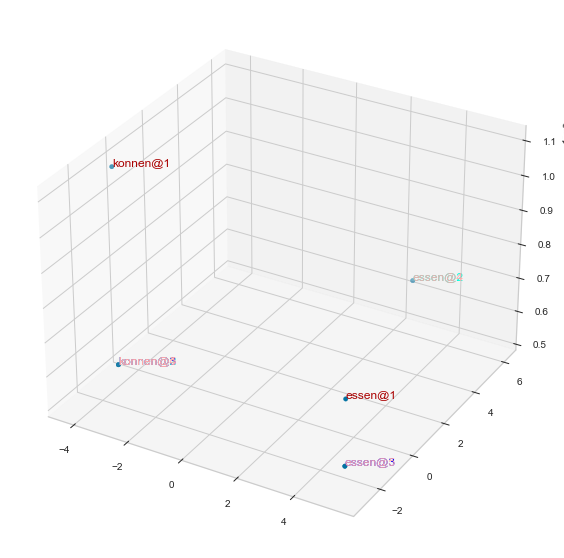

vector_name decoder_encoder_attention@K


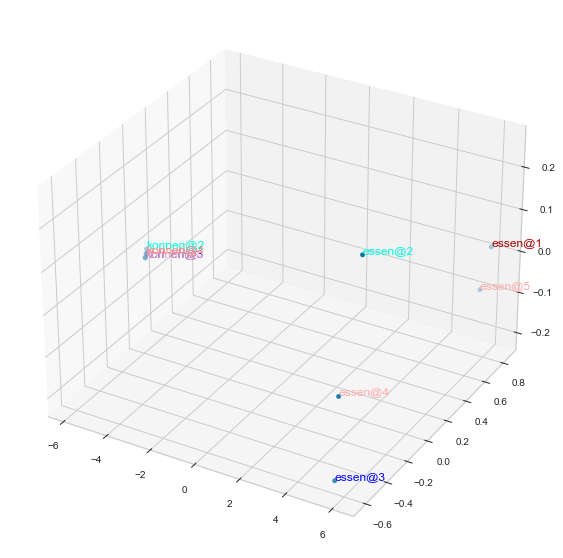

vector_name decoder_encoder_attention@V


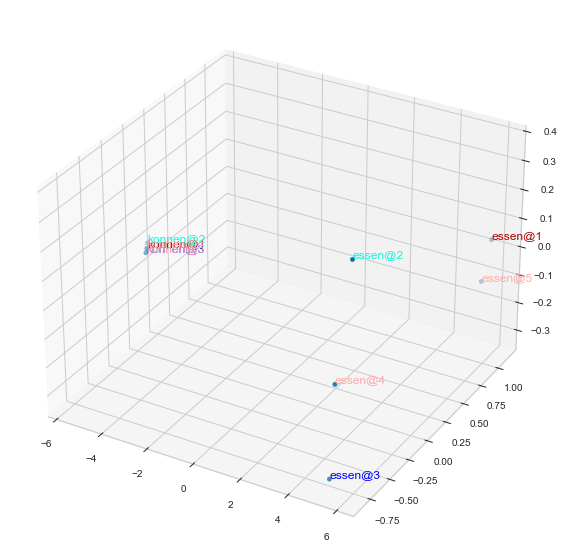

vector_name decoder_encoder_attention@x4


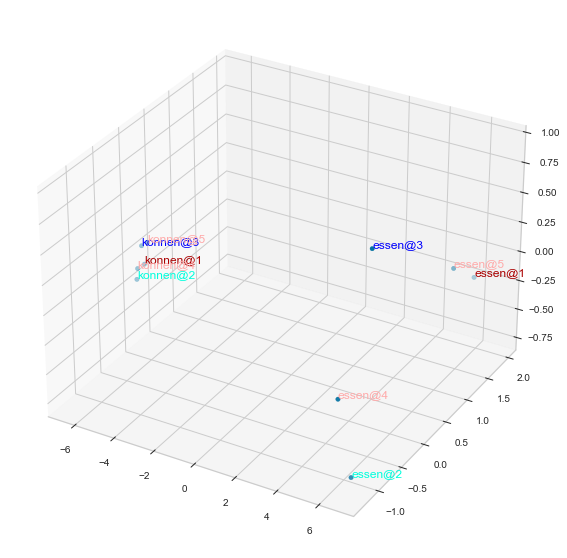

vector_name Decoder@output


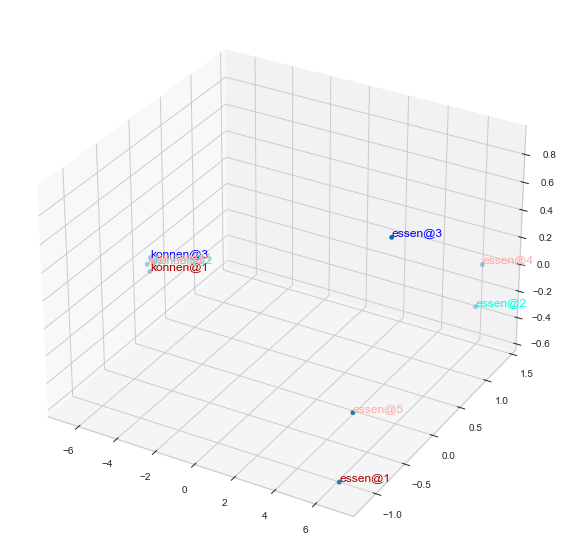

In [66]:
#Do the same for decoder side , this time no need to give keywords


test_sentences = ["i can eat apple","i can eat bread","i can eat book","i can eat newspaper","i can eat apple book"]

indexes = [1,3]
keywords = None

Xs,Ys = collect_sentence_data(test_sentences,"decoder_encoder_attention@Q",indexes,keywords,use_last_vector=True,dump_result=True)
dump_on_surface( Xs,Ys )
Xs,Ys = collect_sentence_data(test_sentences,"decoder_encoder_attention@K",indexes,keywords,use_last_vector=True)
dump_on_surface( Xs,Ys )
Xs,Ys = collect_sentence_data(test_sentences,"decoder_encoder_attention@V",indexes,keywords,use_last_vector=True)
dump_on_surface( Xs,Ys )

Xs,Ys = collect_sentence_data(test_sentences,"decoder_encoder_attention@x4",indexes,keywords,use_last_vector=True)
dump_on_surface( Xs,Ys )

Xs,Ys = collect_sentence_data(test_sentences,"Decoder@output",indexes,keywords,use_last_vector=True)
dump_on_surface( Xs,Ys )



In [67]:
#how does encoding of EAT changes according to time
#lets do over over simplifaction and map is to 1d
search_sentence = "we can eat apple"
steps_for_sample = get_by_word(search_sentence,["eat","apple"],steps_encoder_byword)
X_s1,Y_s1 = map_word_by_sentence(steps_for_sample,includes="QVKX",ranks=[1,15,29])

X1d,Y1d = filter_by_key(X_s1,Y_s1,["eat"])
pca = PCA(n_components=1)
X_transformed = pca.fit_transform(np.array(X1d))
X_transformed = [x[0] for x in X_transformed]

df = pd.DataFrame()


mapped_vals = get_as_map(X_transformed,Y1d,["eat@Q@1","eat@K@1","eat@V@1","eat@X1@1"])


mapped_vals["qvk"] = mapped_vals["eat@Q@1"] * mapped_vals["eat@K@1"] * mapped_vals["eat@V@1"] 
df["apple_0"] = mapped_vals.keys()
df["apple_0 values"] = mapped_vals.values()

mapped_vals = get_as_map(X_transformed,Y1d,["eat@Q@29","eat@K@29","eat@V@29","eat@X1@29"])

mapped_vals["qvk"] = mapped_vals["eat@Q@29"] * mapped_vals["eat@K@29"] * mapped_vals["eat@V@29"] 


df["apple_29"] = mapped_vals.keys()
df["apple_29 values"] = mapped_vals.values()

#----------------------------
search_sentence = "we can eat bread"
steps_for_sample = get_by_word(search_sentence,["eat","bread"],steps_encoder_byword)
X_s1,Y_s1 = map_word_by_sentence(steps_for_sample,includes="QVKX",ranks=[1,15,29])

X1d,Y1d = filter_by_key(X_s1,Y_s1,["eat"])
pca = PCA(n_components=1)
X_transformed = pca.fit_transform(np.array(X1d))
X_transformed = [x[0] for x in X_transformed]

mapped_vals = get_as_map(X_transformed,Y1d,["eat@Q@1","eat@K@1","eat@V@1","eat@X1@1"])
#print("---mapped_vals",mapped_vals.keys())

mapped_vals["qvk"] = mapped_vals["eat@Q@1"] * mapped_vals["eat@K@1"] * mapped_vals["eat@V@1"] 
df["bread_0"] = mapped_vals.keys()
df["bread_0 values"] = mapped_vals.values()

mapped_vals = get_as_map(X_transformed,Y1d,["eat@Q@29","eat@K@29","eat@V@29","eat@X1@29"])
mapped_vals["qvk"] = mapped_vals["eat@Q@29"] * mapped_vals["eat@K@29"] * mapped_vals["eat@V@29"] 

df["bread_29"] = mapped_vals.keys()
df["bread_29 values"] = mapped_vals.values()
df.head(5)
#at 0 values are -195 and 81 = distance 276 
#at 29           -218 and 43 = distance 261

,apple_0,apple_0 values,apple_29,apple_29 values,bread_0,bread_0 values,bread_29,bread_29 values
0,eat@Q@1,3.06,eat@Q@29,3.86,eat@Q@1,-1.19,eat@Q@29,-0.72
1,eat@K@1,8.01,eat@K@29,7.98,eat@K@1,-7.93,eat@K@29,-7.48
2,eat@V@1,-7.97,eat@V@29,-7.09,eat@V@1,8.69,eat@V@29,8.11
3,eat@X1@1,-4.36,eat@X1@29,-4.03,eat@X1@1,0.68,eat@X1@29,-0.34
4,qvk,-195.52,qvk,-218.80,qvk,81.86,qvk,43.38


vector_name Decoder@trg_embedding
source = ['i', 'can', 'eat', 'apple']
predicted target = ['ich', 'konnen', 'apfel', 'essen', '<eos>']
source = ['i', 'can', 'eat', 'bread']
predicted target = ['ich', 'konnen', 'brot', 'essen', '<eos>']


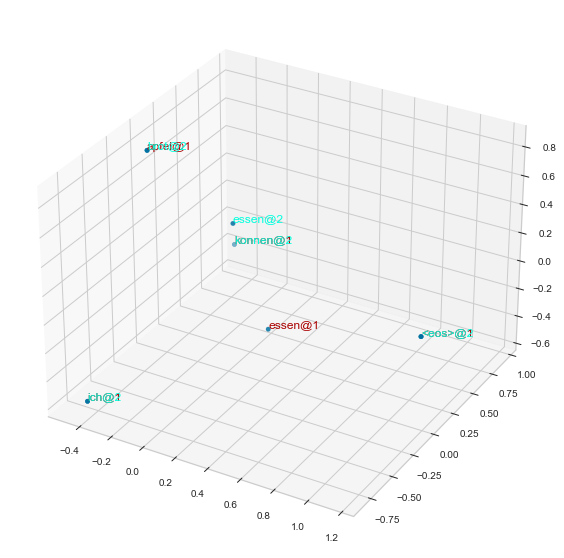

In [68]:
test_sentences = ["i can eat apple","i can eat bread"]

indexes = [0,1,2,3,4]
keywords = None
    
Xs,Ys = collect_sentence_data(test_sentences,"Decoder@trg_embedding",indexes,keywords,use_last_vector=True,dump_result=True)
dump_on_surface( Xs,Ys )

vector_name Encoder@src_embedding
source = ['i', 'can', 'eat', 'apple']
predicted target = ['ich', 'konnen', 'apfel', 'essen', '<eos>']
source = ['i', 'can', 'eat', 'bread']
predicted target = ['ich', 'konnen', 'brot', 'essen', '<eos>']


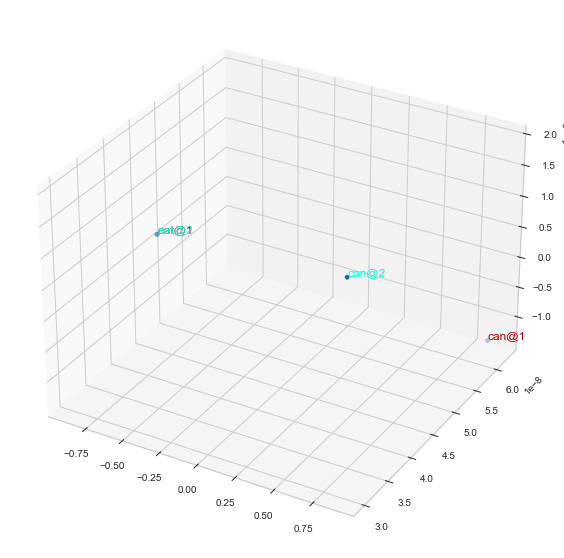

In [69]:
test_sentences = ["i can eat apple","i can eat bread"]
indexes = [2,3]
keywords = ["can","eat"]
    
Xs,Ys = collect_sentence_data(test_sentences,"Encoder@src_embedding",indexes,keywords,use_last_vector=False,dump_result=True)
dump_on_surface( Xs,Ys )

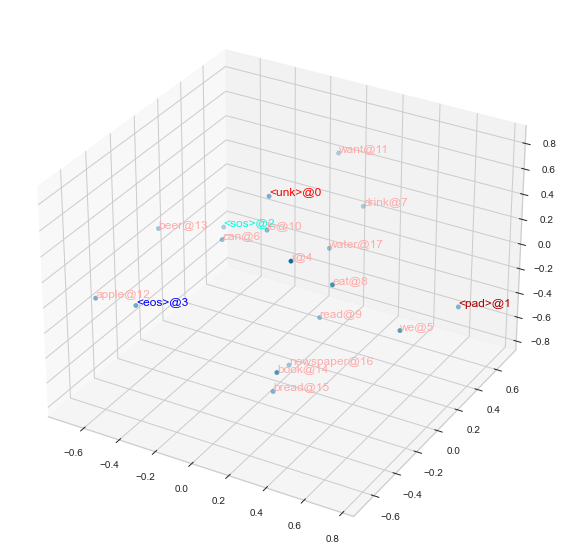

In [70]:
#check distribution of all source language vectors
encoder_embedding = model.encoder.tok_embedding
Xs_src = []
Ys_src = []
for key_index,key in enumerate(SRC.vocab.stoi.keys()):
    if key_index < 18:
        input = torch.LongTensor([key_index])
        
        Xs_src.append( encoder_embedding(input).detach().numpy().flatten() )
        Ys_src.append(key+"@"+str(key_index))
dump_on_surface( Xs_src,Ys_src )   


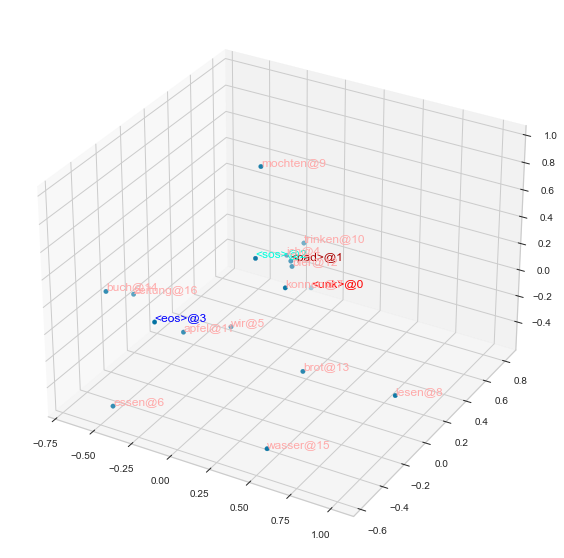

In [71]:
#check distribution of all target language vectors
decoder_embedding = model.decoder.tok_embedding
Xs_trg = []
Ys_trg = []
for key_index,key in enumerate(TRG.vocab.stoi.keys()):
    
    input = torch.LongTensor([key_index])
    Xs_trg.append( decoder_embedding(input).detach().numpy().flatten() )
    Ys_trg.append(key+"@"+str(key_index))
dump_on_surface( Xs_trg,Ys_trg )   

In [72]:
#check similarity or source and tagrget vectors
from sklearn.metrics.pairwise import cosine_similarity
datas = []
for trg_index, y_trg in enumerate(Ys_trg[6:]):
    row_data = []
    for src_index,y_src in enumerate(Ys_src[6:]):
        cell_value = cosine_similarity( Xs_trg[6:][trg_index].reshape(1,64) , Xs_src[6:][src_index].reshape(1,64)  )[0][0]
        row_data.append(cell_value)
    datas.append( row_data )    

draw_df(datas,columns=Ys_src[6:],indexes=Ys_trg[6:])   

,can@6,drink@7,eat@8,read@9,to@10,want@11,apple@12,beer@13,book@14,bread@15,newspaper@16,water@17
essen@6,0.16,-0.06,0.03,-0.00,0.22,0.06,0.29,0.11,-0.14,0.12,-0.08,0.17
konnen@7,-0.10,-0.06,0.13,-0.14,0.04,-0.08,0.20,-0.08,-0.03,-0.12,-0.05,-0.14
lesen@8,0.08,0.13,0.01,-0.14,0.03,0.15,-0.15,0.00,-0.03,-0.06,-0.02,0.07
mochten@9,0.01,-0.10,-0.08,0.05,-0.07,-0.10,0.12,0.20,-0.08,0.17,0.13,-0.03
trinken@10,0.09,-0.21,-0.17,0.15,-0.12,-0.05,0.02,-0.04,0.02,0.06,-0.01,-0.01
apfel@11,0.00,-0.01,0.20,-0.03,0.14,0.07,0.03,0.20,0.08,0.12,0.06,0.03
bier@12,0.02,-0.14,0.01,0.06,0.28,-0.16,-0.00,-0.16,0.15,0.00,-0.10,-0.11
brot@13,0.03,-0.07,-0.04,0.11,0.16,0.01,0.09,-0.14,-0.05,0.05,-0.05,0.01
buch@14,0.13,-0.19,0.19,0.12,-0.24,-0.23,0.02,-0.15,-0.06,0.15,-0.19,0.03
wasser@15,0.21,-0.03,0.17,0.01,0.25,-0.21,0.07,-0.00,-0.11,-0.14,-0.08,0.22


In [73]:
#check similarity  target vectors with each other, as expected diagonal is 1
datas = []
for trg_index, y_trg in enumerate(Ys_trg[4:]):
    row_data = []
    for src_index,y_src in enumerate(Ys_trg[4:]):
        cell_value = cosine_similarity( Xs_trg[4:][trg_index].reshape(1,64) , Xs_trg[4:][src_index].reshape(1,64)  )[0][0]
        row_data.append(cell_value)
    datas.append( row_data )    

draw_df(datas,columns=Ys_trg[4:],indexes=Ys_trg[4:]) 
np.array(datas).shape


,ich@4,wir@5,essen@6,konnen@7,lesen@8,mochten@9,trinken@10,apfel@11,bier@12,brot@13,buch@14,wasser@15,zeitung@16
ich@4,1.00,0.09,-0.14,0.06,-0.02,-0.04,-0.07,-0.06,-0.02,-0.09,-0.01,-0.13,0.11
wir@5,0.09,1.00,0.12,0.09,-0.15,-0.10,-0.00,-0.01,0.00,0.15,0.04,0.01,0.09
essen@6,-0.14,0.12,1.00,-0.09,-0.12,-0.07,-0.06,0.26,-0.13,-0.02,0.08,0.14,0.15
konnen@7,0.06,0.09,-0.09,1.00,0.11,0.14,-0.15,-0.02,0.08,0.15,-0.14,0.03,-0.01
lesen@8,-0.02,-0.15,-0.12,0.11,1.00,-0.09,-0.05,-0.15,-0.06,0.16,-0.25,0.22,-0.22
mochten@9,-0.04,-0.10,-0.07,0.14,-0.09,1.00,0.15,-0.01,-0.02,-0.11,-0.02,-0.11,-0.03
trinken@10,-0.07,-0.00,-0.06,-0.15,-0.05,0.15,1.00,-0.11,0.13,0.09,-0.13,-0.12,0.10
apfel@11,-0.06,-0.01,0.26,-0.02,-0.15,-0.01,-0.11,1.00,0.14,0.01,-0.03,0.08,0.16
bier@12,-0.02,0.00,-0.13,0.08,-0.06,-0.02,0.13,0.14,1.00,0.04,-0.05,0.03,0.00
brot@13,-0.09,0.15,-0.02,0.15,0.16,-0.11,0.09,0.01,0.04,1.00,0.01,0.25,-0.27


(13, 13)

In [74]:
#check similarity  source vectors with each other, as expected diagonal is 1
datas = []
for trg_index, y_trg in enumerate(Ys_src[4:]):
    row_data = []
    for src_index,y_src in enumerate(Ys_src[4:]):
        cell_value = cosine_similarity( Xs_src[4:][trg_index].reshape(1,64) , Xs_src[4:][src_index].reshape(1,64)  )[0][0]
        if trg_index == src_index:
            cell_value = cell_value #0
        row_data.append(cell_value )
    datas.append( row_data )    

draw_df(datas,columns=Ys_src[4:],indexes=Ys_src[4:]) 
np.array(datas).shape

,i@4,we@5,can@6,drink@7,eat@8,read@9,to@10,want@11,apple@12,beer@13,book@14,bread@15,newspaper@16,water@17
i@4,1.00,0.02,-0.18,-0.08,0.27,-0.17,0.06,-0.02,-0.06,-0.08,0.24,-0.11,-0.22,-0.12
we@5,0.02,1.00,-0.00,-0.05,0.12,0.30,-0.09,-0.09,-0.17,-0.18,0.18,-0.08,-0.16,0.02
can@6,-0.18,-0.00,1.00,0.03,-0.03,-0.13,0.06,-0.07,-0.00,0.11,-0.02,-0.01,-0.21,0.09
drink@7,-0.08,-0.05,0.03,1.00,0.01,-0.02,0.11,0.27,-0.16,-0.01,0.09,-0.20,0.20,0.12
eat@8,0.27,0.12,-0.03,0.01,1.00,-0.12,-0.12,-0.12,0.05,-0.07,0.01,-0.11,-0.06,0.13
read@9,-0.17,0.30,-0.13,-0.02,-0.12,1.00,-0.01,-0.08,0.09,0.08,-0.02,-0.08,0.02,0.01
to@10,0.06,-0.09,0.06,0.11,-0.12,-0.01,1.00,-0.10,-0.14,0.14,-0.09,0.05,-0.10,0.07
want@11,-0.02,-0.09,-0.07,0.27,-0.12,-0.08,-0.10,1.00,0.00,0.08,-0.23,-0.26,-0.14,0.04
apple@12,-0.06,-0.17,-0.00,-0.16,0.05,0.09,-0.14,0.00,1.00,0.25,-0.05,-0.02,0.02,-0.11
beer@13,-0.08,-0.18,0.11,-0.01,-0.07,0.08,0.14,0.08,0.25,1.00,-0.01,-0.07,-0.04,0.01


(14, 14)

In [75]:
#check similarity of vectors generated by 2 sentences
def dump_vector_relation(sentences,vector_name,is_q=False,dump_vector=False):
    print("sentence  :",sentences[0])
    print("sentence  :",sentences[1])
    print("Vector :",vector_name)
    test_logger1,_,t1 = test_sentence(sentences[0],attention_type=1,draw_charts=False,dump_result=False)
    val1 = test_logger1.get_summary([vector_name],show_data=False,summary_count=10)

    test_logger2,_,t2 = test_sentence(sentences[1],attention_type=1,draw_charts=False,dump_result=False)
    val2 = test_logger2.get_summary([vector_name],show_data=False,summary_count=10)

    data1 = val1[len(val1)-1][0][0]
    data2 = val2[len(val1)-1][0][0]
    
    
    if vector_name.find("x4") > 0:
        data1 = val1[len(val1)-1][0]
        data2 = val2[len(val2)-1][0]
    
    if dump_vector:
        print("data1")
        print(data1)
        print("data2")
        print(data2)
        
    data_matrix = []
    for i in range(data1.shape[0] ):
        sub_data = []
        for j in range(data2.shape[0] ):
            shape_new = data1[i].shape[0]
            sub_data.append( cosine_similarity(data1[i].reshape(1,shape_new), data2[j].reshape(1,shape_new))[0][0] )
        data_matrix.append( sub_data )
    
    
    columns = ["sos"] + sentences[1].split(" ") + ["eos"]
    indexes = ["sos"] + sentences[0].split(" ") + ["eos"]
    if is_q :
        columns = ["sos"] + t2[:-1] + ["eos"]
        indexes = ["sos"] + t1[:-1] + ["eos"]
        columns = [ columns[i]+"->"+columns[i+1] for i in range(len(columns)-1) ]
        indexes = [ indexes[i]+"->"+indexes[i+1] for i in range(len(indexes)-1) ]
        
        
    
        
    draw_df(data_matrix,columns=columns,indexes=indexes) 
    return 0

In [76]:

   
sentences = ["we can eat apple","we can read bread"]


dump_vector_relation(sentences,"decoder_encoder_attention@x4",True)

dump_vector_relation(sentences,"decoder_encoder_attention@Q",True)

dump_vector_relation(sentences,"decoder_encoder_attention@K")

dump_vector_relation(sentences,"decoder_encoder_attention@V")

dump_vector_relation(sentences,"decoder_encoder_attention@attention",True)



#Q depends on output itself, it is query so always same values
#K  features learned, how output aligns with input
#V  QxK , multiplication of query x features,what was learned

test_logger1,_,t1 = test_sentence(sentences[0],attention_type=1,draw_charts=False,dump_result=False)
val1 = test_logger1.get_summary(["decoder_encoder_attention@attention"],show_data=False,summary_count=10)


test_logger2,_,t2 = test_sentence(sentences[1],attention_type=1,draw_charts=False,dump_result=False)
val2 = test_logger2.get_summary(["decoder_encoder_attention@attention"],show_data=False,summary_count=10)


sentence  : we can eat apple
sentence  : we can read bread
Vector : decoder_encoder_attention@x4


,sos->wir,wir->konnen,konnen->zeitung,zeitung->lesen,lesen->eos
sos->wir,1.00,-0.14,0.35,0.23,0.11
wir->konnen,-0.15,1.00,-0.13,-0.11,0.63
konnen->apfel,-0.35,0.22,-0.31,-0.16,0.03
apfel->essen,-0.03,0.15,-0.31,-0.25,-0.05
essen->eos,-0.42,0.24,-0.35,-0.16,0.03


sentence  : we can eat apple
sentence  : we can read bread
Vector : decoder_encoder_attention@Q


,sos->wir,wir->konnen,konnen->zeitung,zeitung->lesen,lesen->eos
sos->wir,1.00,0.25,-0.09,-0.35,-0.06
wir->konnen,0.25,1.00,-0.30,0.01,-0.13
konnen->apfel,-0.09,-0.30,1.00,0.35,0.24
apfel->essen,-0.14,-0.09,-0.16,0.02,-0.19
essen->eos,-0.33,-0.27,-0.18,-0.06,0.14


sentence  : we can eat apple
sentence  : we can read bread
Vector : decoder_encoder_attention@K


,sos,we,can,read,bread,eos
sos,0.66,-0.31,0.07,-0.05,0.14,0.42
we,-0.17,1.00,-0.27,-0.01,-0.05,-0.11
can,-0.14,-0.28,1.00,-0.08,-0.27,-0.11
eat,0.16,0.06,0.05,0.08,0.02,0.18
apple,0.20,-0.27,-0.04,0.09,0.30,0.39
eos,0.30,-0.20,-0.06,-0.11,0.32,0.74


sentence  : we can eat apple
sentence  : we can read bread
Vector : decoder_encoder_attention@V


,sos,we,can,read,bread,eos
sos,0.55,-0.27,0.14,-0.04,0.16,0.19
we,-0.12,1.00,-0.13,0.34,-0.03,-0.23
can,-0.20,-0.14,1.00,-0.01,-0.10,0.03
eat,0.06,-0.10,0.11,-0.14,0.19,-0.01
apple,-0.12,-0.14,0.02,0.02,0.02,0.21
eos,0.09,-0.37,0.25,-0.19,0.12,0.60


sentence  : we can eat apple
sentence  : we can read bread
Vector : decoder_encoder_attention@attention


,sos->wir,wir->konnen,konnen->zeitung,zeitung->lesen,lesen->eos
sos->wir,1.00,0.01,0.02,0.05,0.04
wir->konnen,0.01,1.00,0.04,0.13,0.80
konnen->apfel,0.06,0.10,0.12,0.45,0.39
apfel->essen,0.06,0.04,0.99,0.92,0.62
essen->eos,0.04,0.04,0.08,0.50,0.23


In [77]:
#same sentence all diagonals must be same
sentences = ["we can eat apple","we can eat apple"]

dump_vector_relation(sentences,"decoder_encoder_attention@Q",True)

dump_vector_relation(sentences,"decoder_encoder_attention@K")

dump_vector_relation(sentences,"decoder_encoder_attention@V")

dump_vector_relation(sentences,"decoder_encoder_attention@x4",True)

sentence  : we can eat apple
sentence  : we can eat apple
Vector : decoder_encoder_attention@Q


,sos->wir,wir->konnen,konnen->apfel,apfel->essen,essen->eos
sos->wir,1.00,0.25,-0.09,-0.14,-0.33
wir->konnen,0.25,1.00,-0.30,-0.09,-0.27
konnen->apfel,-0.09,-0.30,1.00,-0.16,-0.18
apfel->essen,-0.14,-0.09,-0.16,1.00,0.19
essen->eos,-0.33,-0.27,-0.18,0.19,1.00


sentence  : we can eat apple
sentence  : we can eat apple
Vector : decoder_encoder_attention@K


,sos,we,can,eat,apple,eos
sos,1.00,-0.30,0.08,0.32,0.49,0.65
we,-0.30,1.00,-0.27,0.07,-0.27,-0.19
can,0.08,-0.27,1.00,0.06,-0.03,-0.05
eat,0.32,0.07,0.06,1.00,0.45,0.34
apple,0.49,-0.27,-0.03,0.45,1.00,0.65
eos,0.65,-0.19,-0.05,0.34,0.65,1.00


sentence  : we can eat apple
sentence  : we can eat apple
Vector : decoder_encoder_attention@V


,sos,we,can,eat,apple,eos
sos,1.00,-0.26,0.15,0.18,0.27,0.51
we,-0.26,1.00,-0.13,-0.09,-0.14,-0.37
can,0.15,-0.13,1.00,0.12,0.02,0.25
eat,0.18,-0.09,0.12,1.00,0.18,0.22
apple,0.27,-0.14,0.02,0.18,1.00,0.62
eos,0.51,-0.37,0.25,0.22,0.62,1.00


sentence  : we can eat apple
sentence  : we can eat apple
Vector : decoder_encoder_attention@x4


,sos->wir,wir->konnen,konnen->apfel,apfel->essen,essen->eos
sos->wir,1.00,-0.14,-0.32,0.02,-0.40
wir->konnen,-0.14,1.00,0.25,0.20,0.27
konnen->apfel,-0.32,0.25,1.00,0.49,0.97
apfel->essen,0.02,0.20,0.49,1.00,0.46
essen->eos,-0.40,0.27,0.97,0.46,1.00


0

In [78]:
#order and  object is different
sentences = ["we can eat apple","eat bread can we"]

dump_vector_relation(sentences,"decoder_encoder_attention@Q",True)

dump_vector_relation(sentences,"decoder_encoder_attention@K")

dump_vector_relation(sentences,"decoder_encoder_attention@V")

dump_vector_relation(sentences,"decoder_encoder_attention@x4",True)

dump_vector_relation(sentences,"decoder_encoder_attention@attention",True,dump_vector=False)

sentence  : we can eat apple
sentence  : eat bread can we
Vector : decoder_encoder_attention@Q


,sos->wir,wir->konnen,konnen->brot,brot->essen,essen->eos
sos->wir,1.00,0.25,-0.09,0.18,-0.33
wir->konnen,0.25,1.00,-0.30,0.49,-0.27
konnen->apfel,-0.09,-0.30,1.00,-0.07,-0.18
apfel->essen,-0.14,-0.09,-0.16,0.12,0.18
essen->eos,-0.33,-0.27,-0.18,-0.23,1.00


sentence  : we can eat apple
sentence  : eat bread can we
Vector : decoder_encoder_attention@K


,sos,eat,bread,can,we,eos
sos,0.67,0.22,0.12,0.10,-0.26,0.43
we,-0.18,0.15,-0.07,-0.29,0.99,-0.12
can,-0.13,0.06,-0.22,1.00,-0.27,-0.09
eat,0.17,0.98,0.04,0.05,0.07,0.19
apple,0.21,0.35,0.31,-0.02,-0.25,0.40
eos,0.31,0.25,0.31,-0.04,-0.16,0.75


sentence  : we can eat apple
sentence  : eat bread can we
Vector : decoder_encoder_attention@V


,sos,eat,bread,can,we,eos
sos,0.56,0.06,0.16,0.16,-0.24,0.20
we,-0.12,-0.03,-0.01,-0.16,0.99,-0.23
can,-0.19,0.08,-0.07,1.00,-0.12,0.04
eat,0.06,0.97,0.19,0.12,-0.10,-0.01
apple,-0.11,0.10,0.02,0.04,-0.13,0.22
eos,0.10,0.08,0.12,0.26,-0.34,0.61


sentence  : we can eat apple
sentence  : eat bread can we
Vector : decoder_encoder_attention@x4


,sos->wir,wir->konnen,konnen->brot,brot->essen,essen->eos
sos->wir,0.99,-0.16,0.03,0.16,-0.12
wir->konnen,-0.14,1.00,-0.14,0.11,-0.16
konnen->apfel,-0.30,0.26,0.13,0.13,0.22
apfel->essen,0.05,0.22,0.09,0.91,0.07
essen->eos,-0.37,0.27,0.17,0.10,0.29


sentence  : we can eat apple
sentence  : eat bread can we
Vector : decoder_encoder_attention@attention


,sos->wir,wir->konnen,konnen->brot,brot->essen,essen->eos
sos->wir,0.06,0.08,0.03,1.00,0.08
wir->konnen,0.01,0.04,0.88,0.03,0.14
konnen->apfel,0.67,0.07,0.45,0.12,0.75
apfel->essen,0.08,0.98,0.15,0.11,0.21
essen->eos,0.11,0.06,0.46,0.08,0.99


0

In [79]:

sentences = ["we can eat apple","apple eat can we"]



dump_vector_relation(sentences,"decoder_encoder_attention@Q",True)

dump_vector_relation(sentences,"decoder_encoder_attention@K")

dump_vector_relation(sentences,"decoder_encoder_attention@V")

dump_vector_relation(sentences,"decoder_encoder_attention@x4",True)

dump_vector_relation(sentences,"decoder_encoder_attention@attention",True,dump_vector=True)

sentence  : we can eat apple
sentence  : apple eat can we
Vector : decoder_encoder_attention@Q


,sos->wir,wir->konnen,konnen->apfel,apfel->essen,essen->eos
sos->wir,1.00,0.25,-0.09,-0.14,-0.33
wir->konnen,0.25,1.00,-0.30,-0.09,-0.27
konnen->apfel,-0.09,-0.30,1.00,-0.16,-0.18
apfel->essen,-0.14,-0.09,-0.16,1.00,0.19
essen->eos,-0.33,-0.27,-0.18,0.19,1.00


sentence  : we can eat apple
sentence  : apple eat can we
Vector : decoder_encoder_attention@K


,sos,apple,eat,can,we,eos
sos,1.00,0.46,0.29,0.10,-0.26,0.65
we,-0.30,-0.27,0.09,-0.29,0.99,-0.19
can,0.09,-0.03,0.09,1.00,-0.27,-0.05
eat,0.32,0.45,1.00,0.06,0.08,0.33
apple,0.48,0.99,0.41,-0.02,-0.25,0.65
eos,0.65,0.62,0.30,-0.04,-0.16,1.00


sentence  : we can eat apple
sentence  : apple eat can we
Vector : decoder_encoder_attention@V


,sos,apple,eat,can,we,eos
sos,1.00,0.24,0.16,0.16,-0.23,0.50
we,-0.26,-0.14,-0.07,-0.16,0.99,-0.36
can,0.15,0.01,0.15,1.00,-0.12,0.25
eat,0.18,0.19,1.00,0.12,-0.10,0.21
apple,0.26,1.00,0.16,0.04,-0.13,0.63
eos,0.50,0.60,0.20,0.26,-0.34,1.00


sentence  : we can eat apple
sentence  : apple eat can we
Vector : decoder_encoder_attention@x4


,sos->wir,wir->konnen,konnen->apfel,apfel->essen,essen->eos
sos->wir,0.99,-0.17,-0.32,0.05,-0.39
wir->konnen,-0.13,1.00,0.25,0.23,0.27
konnen->apfel,-0.28,0.28,1.00,0.47,0.97
apfel->essen,0.04,0.22,0.48,1.00,0.45
essen->eos,-0.36,0.29,0.96,0.44,1.00


sentence  : we can eat apple
sentence  : apple eat can we
Vector : decoder_encoder_attention@attention
data1
tensor([[0.0026, 0.9656, 0.0070, 0.0191, 0.0019, 0.0038],
        [0.0066, 0.0059, 0.9456, 0.0379, 0.0026, 0.0014],
        [0.3318, 0.0261, 0.0510, 0.0341, 0.3486, 0.2084],
        [0.1323, 0.0341, 0.0239, 0.7284, 0.0513, 0.0299],
        [0.3704, 0.0176, 0.0209, 0.0333, 0.0590, 0.4989]])
data2
tensor([[0.0035, 0.0037, 0.0345, 0.0072, 0.9461, 0.0050],
        [0.0070, 0.0034, 0.0503, 0.9327, 0.0052, 0.0015],
        [0.3235, 0.3576, 0.0327, 0.0477, 0.0258, 0.2127],
        [0.1432, 0.0463, 0.7046, 0.0280, 0.0464, 0.0315],
        [0.3779, 0.0500, 0.0313, 0.0218, 0.0200, 0.4989]])


,sos->wir,wir->konnen,konnen->apfel,apfel->essen,essen->eos
sos->wir,0.01,0.02,0.68,0.07,0.09
wir->konnen,0.04,0.09,0.07,0.98,0.06
konnen->apfel,0.67,0.08,0.62,0.28,0.72
apfel->essen,0.08,0.98,0.25,0.11,0.18
essen->eos,0.10,0.06,0.71,0.19,1.00


0

In [80]:
#do the vector relation logic for encoder layers
def dump_vector_relation_encoder(sentences,vector_name,is_q=False):
    print("Vector :",vector_name)
    test_logger1,_,t1 = test_sentence(sentences[0],attention_type=1,draw_charts=False,dump_result=False)
    val1 = test_logger1.get_summary([vector_name],show_data=False,summary_count=10)

    test_logger2,_,t2 = test_sentence(sentences[1],attention_type=1,draw_charts=False,dump_result=False)
    val2 = test_logger2.get_summary([vector_name],show_data=False,summary_count=10)

    data1 = val1[len(val1)-1][0][0]
    data2 = val2[len(val1)-1][0][0]
    data_matrix = []
    for i in range(data1.shape[0] ):
        sub_data = []
        for j in range(data2.shape[0] ):
            sub_data.append( cosine_similarity(data1[i].reshape(1,64), data2[j].reshape(1,64))[0][0] )
        data_matrix.append( sub_data )
    
    print("data1",data1.shape)
    columns = ["sos"] + sentences[1].split(" ") + ["eos"]
    indexes = ["sos"] + sentences[0].split(" ") + ["eos"]
    if is_q :
        columns =  ["sos"]+sentences[1].split(" ") + ["eos"]
        indexes =  ["sos"]+sentences[0].split(" ") + ["eos"]
        
    draw_df(data_matrix,columns=columns,indexes=indexes) 
    
#sentences = ["we can eat apple","i can read book"]
sentences = ["we can eat apple","we can eat bread"]

dump_vector_relation_encoder(sentences,"encoder@Q",True)

dump_vector_relation_encoder(sentences,"encoder@K")

dump_vector_relation_encoder(sentences,"encoder@V")

Vector : encoder@Q
data1 torch.Size([6, 64])


,sos,we,can,eat,bread,eos
sos,1.00,-0.10,0.01,0.09,0.09,0.02
we,-0.10,1.00,0.17,0.04,0.04,-0.07
can,0.01,0.17,1.00,0.05,-0.01,0.17
eat,0.09,0.04,0.05,1.00,-0.00,0.03
apple,-0.09,-0.14,0.03,0.08,-0.09,0.32
eos,0.02,-0.07,0.17,0.03,0.21,1.00


Vector : encoder@K
data1 torch.Size([6, 64])


,sos,we,can,eat,bread,eos
sos,1.00,-0.05,0.04,0.12,-0.12,0.29
we,-0.05,1.00,-0.07,0.17,-0.08,-0.05
can,0.04,-0.07,1.00,-0.04,-0.12,0.24
eat,0.12,0.17,-0.04,1.00,-0.15,-0.12
apple,0.12,-0.25,0.04,-0.01,0.01,0.30
eos,0.29,-0.05,0.24,-0.12,0.14,1.00


Vector : encoder@V
data1 torch.Size([6, 64])


,sos,we,can,eat,bread,eos
sos,1.00,-0.13,0.15,-0.24,-0.23,-0.06
we,-0.13,1.00,0.09,0.07,-0.11,-0.12
can,0.15,0.09,1.00,-0.13,-0.21,0.14
eat,-0.24,0.07,-0.13,1.00,-0.18,-0.03
apple,0.01,-0.17,0.12,0.08,-0.09,0.27
eos,-0.06,-0.12,0.14,-0.03,-0.08,1.00


In [81]:
#test_logger.get_default_summary(show_data=True)
for index in range(20,22):
    
    test_logger,all_outputs,_ = test_sentence(tabular_set[index].src,draw_charts=False,attention_type=1)
    encoded_attention = test_logger.get_summary(["EncoderLayer@sattention"],show_data=False)
    
    src_masks = test_logger.get_summary(["EncoderLayer@src_mask"],show_data=False,summary_count=10)
    #print("EncoderLayersrc_masks",src_masks)
    
    decodersrc_masks = test_logger.get_summary(["DecoderLayer@src_mask"],show_data=False,summary_count=10)
    #print("decodersrc_masks",decodersrc_masks)
    
    
    decoder_attention = test_logger.get_summary(["Decoder@attention"],show_data=False,summary_count=10)
    #print("decoder_attention",decoder_attention[0].shape)
    #print("decoder_attention",decoder_attention[0])
    
    decodertrg_masks = test_logger.get_summary(["DecoderLayer@trg_mask"],show_data=False,summary_count=10)
    #for index2,dm in enumerate(decodertrg_masks):
    #    print("decodertrg_masks",index2)
    #    print(dm)
    
    output_words = ["sos"]+tabular_set[index].src  +["eos"]
    for head_index in range(encoded_attention[0].shape[1]):
        all_outputs0 = encoded_attention[0][:,head_index,:,:]
        draw_df(all_outputs0.squeeze().numpy(),output_words,output_words)
    
    ### OPEN THIS COMMENT FOR MULTI HEAD all_outputs1 = encoded_attention[0][:,1,:,:]
    ###draw_df(all_outputs1.squeeze().numpy(),output_words,output_words)


#i want to read newspaper  diagonal
#i can eat bread  diagonal
#we can eat bread diagonal
#we can read book , very diagonal
#we can read newspaper , very diagonal
#i eat bread , very diagonal
#when want to comes into ,patterns change

source = ['we', 'can', 'drink', 'water']
predicted target = ['wir', 'konnen', 'wasser', 'trinken', '<eos>']


,sos,we,can,drink,water,eos
sos,0.00,0.00,0.01,0.57,0.41,0.01
we,0.00,0.94,0.04,0.01,0.00,0.01
can,0.00,0.18,0.73,0.03,0.02,0.04
drink,0.07,0.00,0.01,0.01,0.86,0.04
water,0.01,0.04,0.06,0.09,0.78,0.02
eos,0.01,0.00,0.03,0.02,0.93,0.01


source = ['we', 'can', 'drink', 'beer']
predicted target = ['wir', 'konnen', 'bier', 'trinken', '<eos>']


,sos,we,can,drink,beer,eos
sos,0.00,0.00,0.01,0.95,0.01,0.02
we,0.00,0.94,0.04,0.01,0.00,0.01
can,0.00,0.18,0.73,0.03,0.02,0.04
drink,0.07,0.00,0.01,0.01,0.87,0.04
beer,0.01,0.02,0.46,0.28,0.20,0.03
eos,0.04,0.01,0.11,0.08,0.72,0.05
